# MODELOS PREDICTIVOS COVID MURCIA

In [1]:
from pandas import read_csv
import pandas as pd
from pandas.plotting import lag_plot
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import io
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm

Lectura del conjunto de datos obtenido de la pagina de salud de Murcia 
https://www.murciasalud.es/pagina.php?id=458869
Recogidos desde el 08/03/2020 hasta el dia 25/03/2020

In [2]:
lectura = read_csv('../Datos_originales/casos_diarios_total_regional.csv', skiprows = 4, encoding='latin-1', sep = ';', na_values = ['NaN', 'NaT'])

# Headers = columnas de mi conjunto de datos. Si no especificamos asume que son las de la primera fila leida
# Skiprows = n: con n = numero de filas que quiero saltar. Las cuatro primeras son texto -> las saltamos
# Encoding = 'latin-1': para que no de errores de codificacion de algunos caracteres 
# Sep = ';': delimitador que separa las columnas
# Index_col = 0: usar la primera columna (fechas) como filas del dataframe

Renombramos los nombres de algunas de las columnas para que queden mas compactos

In [3]:
datos = lectura.rename(columns={'Pruebas_PCR_Ag':'Pruebas',
                                'Casos_incidentes_PCR/Ag+':'Incidentes',
                                'Hospitalizados': 'H',
                                'Hospitaliz_UCI':'H_UCI',
                                'Asintomatico_hombre_<45años': 'Asint_H_<45',
                                'Asintomatico_hombre_45a64años': 'Asint_H_45a64',
                                'Asintomatico_hombre_+65años': 'Asint_H_+65',
                                'Sintomatico_hombre_<45años': 'Sint_H_<45',
                                'Sintomatico_hombre_45a64años': 'Sint_H_45a64',
                                'Sintomatico_hombre_+65años': 'Sint_H_+65',
                                'Asintomatico_mujer_<45años': 'Asint_M_<45',
                                'Asintomatico_mujer_45a64años': 'Asint_M_45a64',
                                'Asintomatico_mujer_+65años': 'Asint_M_+65',
                                'Sintomatico_mujer_<45años': 'Sint_M_<45',
                                'Sintomatico_mujer_45a64años': 'Sint_M_45a64',
                                'Sintomatico_mujer_+65años': 'Sint_M_+65'})

Convertimos los datos leidos en un dataFrame y lo mostramos para ver su apariencia

In [4]:
df_salud_murcia = pd.DataFrame(datos)
df_salud_murcia.head(3)

Fecha  Pruebas  Incidentes    H  H_UCI  Defunciones  Asint_H_<45  \
0  08/03/2020    130.0         1.0  0.0    0.0          0.0          1.0   
1  09/03/2020     21.0         3.0  0.0    0.0          0.0          0.0   
2  10/03/2020     39.0         6.0  0.0    0.0          0.0          0.0   

   Asint_H_45a64  Asint_H_+65  Sint_H_<45  Sint_H_45a64  Sint_H_+65  \
0            0.0          0.0         0.0           0.0         0.0   
1            0.0          0.0         0.0           1.0         0.0   
2            0.0          0.0         1.0           0.0         1.0   

   Asint_M_<45  Asint_M_45a64  Asint_M_+65  Sint_M_<45  Sint_M_45a64  \
0          1.0            0.0          0.0         1.0           0.0   
1          0.0            0.0          0.0         3.0           0.0   
2          0.0            0.0          0.0         2.0           0.0   

   Sint_M_+65  
0         0.0  
1         0.0  
2         0.0

Lo siguiente que haremos es indexar el dataframe por la columna 'Fecha'. Para ello, primero debemos convertir la misma en un objeto de tipo DatatimeIndex. Usamos la funcion 'to_datetime' y le indicamos el formato en el que se encuentran las fechas para que se lea y procese bien. Posteriormente eliminamos la columna del dataFrame e insertamos el nuevo DatatimeIndex como íncide del dataframe. Finalmente mostramos el resultado.

In [5]:
format = '%d/%m/%Y'
datetime_fecha = pd.to_datetime(df_salud_murcia['Fecha'], format = format)
df_salud_murcia = df_salud_murcia.drop(['Fecha'], axis=1)
df_salud_murcia.insert(0,'Fecha', datetime_fecha)
df_salud_murcia = df_salud_murcia.set_index('Fecha')
df_salud_murcia.head(3)

Pruebas  Incidentes    H  H_UCI  Defunciones  Asint_H_<45  \
Fecha                                                                   
2020-03-08    130.0         1.0  0.0    0.0          0.0          1.0   
2020-03-09     21.0         3.0  0.0    0.0          0.0          0.0   
2020-03-10     39.0         6.0  0.0    0.0          0.0          0.0   

            Asint_H_45a64  Asint_H_+65  Sint_H_<45  Sint_H_45a64  Sint_H_+65  \
Fecha                                                                          
2020-03-08            0.0          0.0         0.0           0.0         0.0   
2020-03-09            0.0          0.0         0.0           1.0         0.0   
2020-03-10            0.0          0.0         1.0           0.0         1.0   

            Asint_M_<45  Asint_M_45a64  Asint_M_+65  Sint_M_<45  Sint_M_45a64  \
Fecha                                                                           
2020-03-08          1.0            0.0          0.0         1.0           0.0   
2020-03-09          0.0            0.0          0.0         3.0           0.0   
2020-03-10          0.0            0.0          0.0         2.0           0.0   

            Sint_M_+65  
Fecha                   
2020-03-08         0.0  
2020-03-09         0.0  
2020-03-10         0.0

Con la siguiente función eliminamos todos aquellos valores que se almacenan o completan como NaN. 

In [6]:
df_salud_murcia.dropna(axis = 0, inplace = True)

## Sumando sintomáticos y asintomáticos

Sumamos asintomáticos y sintomáticos. Eliminamos los grupos y nos quedamos con el total de cada uno

In [7]:
df_salud_murcia['Asintomaticos'] = df_salud_murcia['Asint_H_<45'] + df_salud_murcia['Asint_H_45a64'] + df_salud_murcia['Asint_H_+65'] + df_salud_murcia['Asint_M_<45'] + df_salud_murcia['Asint_M_45a64'] + df_salud_murcia['Asint_M_+65']
df_salud_murcia['Sintomaticos'] = df_salud_murcia['Sint_H_<45'] + df_salud_murcia['Sint_H_45a64'] + df_salud_murcia['Sint_H_+65'] + df_salud_murcia['Sint_M_<45'] + df_salud_murcia['Sint_M_45a64'] + df_salud_murcia['Sint_M_+65']

In [8]:
df_salud_murcia = df_salud_murcia.drop(['Asint_H_<45', 'Asint_H_45a64', 'Asint_H_+65', 'Asint_M_<45', 'Asint_M_45a64', 'Asint_M_+65', 'Sint_H_<45', 'Sint_H_45a64', 'Sint_H_+65', 'Sint_M_<45', 'Sint_M_45a64', 'Sint_M_+65'], axis=1)

A continuación lo que hacemos es guardarla en un archivo de extensión .csv 

In [9]:
df_salud_murcia.to_csv(path_or_buf = '../Datos_preprocesados/salud_murcia.csv')

Al igual que hicimos con el dataFrame de los datos de salud que leímos al principio, debemos transformar las fechas en objetos de tipo DatatimeIndex. Posteriormente las ordenaremos para que se muestren en orden cronológico. Para ello usamos la función 'to_datetime', que convierte nuestra lista de fechas en DatatimeIndex. Acto seguido creamos el dataframe con las entradas, las salidas a Murcia y las fechas y las ponemos como índice del dataframe. Ahora solo queda ordenarlo. Añadimos tres columnas adicionales al dataframe que son los meses, dias y años de las fechas. Ordenamos según estos valores y posteriormente las eliminamos del dataframe. Mostramos el resultado.

In [10]:
def conversor_a_dataframe(lista_fechas, lista_entradas, lista_salidas):
    format = '%Y-%d-%m'
    # Convertimos en DatatimeIndex
    fechas_serie = pd.to_datetime(lista_fechas, format = format)
    # Creamos dataframe con las entradas salidas y fechas
    df_entradas_salidas = pd.DataFrame(list(zip(lista_entradas, lista_salidas)), columns = ['Entradas', 'Salidas'], index = fechas_serie).rename_axis('Fecha', axis = 0)
    # Definimos las series para ordenar
    df_entradas_salidas['month'] = fechas_serie.month
    df_entradas_salidas['year'] = fechas_serie.year
    df_entradas_salidas['day'] = fechas_serie.day
    # Ordenamos por mes-dia-año
    df_entradas_salidas = df_entradas_salidas.sort_values(['year', 'month', 'day']).drop(columns=['day', 'month', 'year'])
    return df_entradas_salidas

## Añadiendo Movilidad

Necesitamos añadir los datos de movilidad proporcionados por el Ministerio de Transporte y Movilidad en la Región de Murcia.
Para ello se buscaron los códigos de los municipios murcianos así como sus correspondientes códigos para el Ministerio, ya que no siempre coinciden. 

La siguiente función permite parsear las fechas, a partir del nombre del fichero obtenemos la fecha correspondiente

In [11]:
def parseador_fechas_mitma(nombre):
    # Cogemos el día
    dia = nombre[6:8]
    mes = nombre[4:6]
    anio = nombre[0:4]
    return(anio+'-'+dia+'-'+mes)

La lista "codigos" contiene todos los códigos de los municipios de la Región con la codificación usada por el Ministerio

In [12]:
# Los diferentes al resto
codigos = ['30901', '30902']

for i in range(1,44):
    if i < 10 and i not in [4,6]:
        codigos.append('3000'+str(i))
    if i >= 10 and i not in [14,27,29,31,32,34,39,40,42]:
        codigos.append('300'+str(i))
    if i == 4:
        codigos.append('30014_AM')
    if i == 6:
        codigos.append('30039_AM')
    if i == 14:
        codigos.append('30014_AM')
    if i == 27:
        codigos.append('3002701')
    if i == 29:
        codigos.append('30029_AM')
    if i == 31:
        codigos.append('30042_AM')
    if i == 32:
        codigos.append('30029_AM')
    if i == 34:
        codigos.append('30014_AM')
    if i == 39:
        codigos.append('30039_AM')
    if i == 40:
        codigos.append('30042_AM')
    if i == 42:
        codigos.append('30042_AM')

Lo siguiente que haremos es procesar todos los datos que tenemos. Para cada archivo, nos quedamos con las salidas y entradas en la Región de Murcia, esto es, no se considera la movilidad entre distintos municipios murcianos si no las salidas y entradas de municipios fuera de la Región hacia ella o desde municipios de la Región hasta municipios fuera de ella

In [13]:
ruta = '../Datos_originales/mitma_movilidad/'

lista_fechas = []
lista_entradas = []
lista_salidas = []


# Cogemos los archivos .tar mensuales
archivos = os.listdir(ruta)

for a in archivos:
    meses = os.listdir(ruta+a)
    for m in meses:
        if "._" not in m:
            # Obtenemos la fecha
            fecha = parseador_fechas_mitma(m)
            lista_fechas.append(fecha)
            # Leemos el archivo correspondiente
            df = pd.read_csv(ruta+a+'/'+m, compression='gzip', sep='|', header=0, low_memory = False)
            # Nos quedamos solo con los viajes en la Región
            df_s = df[df['origen'].isin(codigos)]
            # Eliminamos los viajes dentro de la Región
            df_s = df_s[~df_s['destino'].isin(codigos)]
            df_e = df[df['destino'].isin(codigos)]
            # Eliminamos los viajes de Murcia a Murcia
            df_e = df_e[~df_e['origen'].isin(codigos)]
            # Sumamos todos los viajes que son las entradas y salidas
            salidas = df_s['viajes'].sum()
            entradas = df_e['viajes'].sum()
            # Añadimos a las listas
            lista_salidas.append(salidas)
            lista_entradas.append(entradas)

Convertimos los datos recogidos en un dataframe mediante la función definida anteriormente

In [14]:
df_mitma = conversor_a_dataframe(lista_fechas, lista_entradas, lista_salidas)
df_mitma.tail(3)

Entradas     Salidas
Fecha                             
2021-02-26  130495.728  126471.246
2021-02-27   73285.851   71385.928
2021-02-28   49817.997   49735.536

Vemos ahora el número de filas y el número de missing values

In [15]:
df_mitma.shape

(374, 2)

In [16]:
df_mitma.isna().sum()

Entradas    0
Salidas     0
dtype: int64

Guardamos el conjunto de datos con la movilidad en un nuevo archivo csv

In [17]:
df_mitma.to_csv(path_or_buf = '../Datos_preprocesados/movilidad.csv')

## Juntando los datos

En este apartado se juntan los dataframe de las dos fuentes de datos que se han procesado. De esta forma, a los datos de salud se le añaden los datos de movilidad

In [18]:
df_salud_movilidad = pd.concat([df_salud_murcia, df_mitma], axis=1)

In [19]:
df_salud_movilidad.head(3)

Pruebas  Incidentes   H  H_UCI  Defunciones  Asintomaticos  \
Fecha                                                                    
2020-02-21      NaN         NaN NaN    NaN          NaN            NaN   
2020-02-22      NaN         NaN NaN    NaN          NaN            NaN   
2020-02-23      NaN         NaN NaN    NaN          NaN            NaN   

            Sintomaticos    Entradas     Salidas  
Fecha                                             
2020-02-21           NaN  166795.814  168567.936  
2020-02-22           NaN  144424.897  144077.722  
2020-02-23           NaN  138142.960  133974.435

In [20]:
df_salud_movilidad.dropna(axis = 0, inplace = True)

In [21]:
df_salud_movilidad.to_csv(path_or_buf = '../Datos_preprocesados/salud_movilidad.csv')

In [2]:
df_salud_movilidad = read_csv('../Datos_preprocesados/salud_movilidad.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_salud_movilidad = df_salud_movilidad.set_index('Fecha')

Contamos de nuevo las filas y el número de missing values y los eliminamos

In [26]:
df_salud_movilidad.shape

(358, 9)

In [27]:
df_salud_movilidad.isna().sum()

Pruebas          0
Incidentes       0
H                0
H_UCI            0
Defunciones      0
Asintomaticos    0
Sintomaticos     0
Entradas         0
Salidas          0
dtype: int64

## Visualización de series

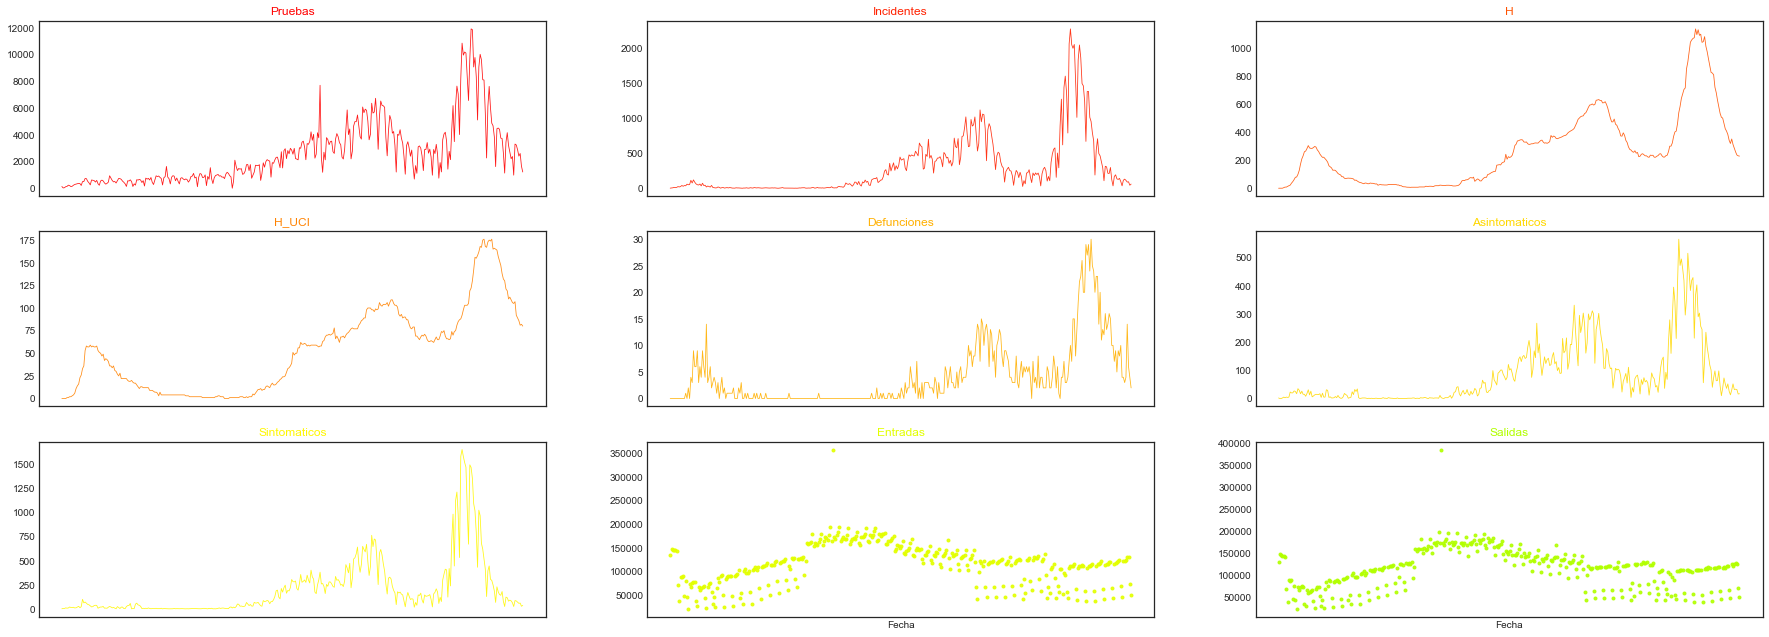

In [28]:
num = 0

# Initialize the figure style
plt.style.use('seaborn-white')
 
# create a color palette

palette = plt.get_cmap('prism')

for column in df_salud_movilidad:
    
    num = num + 1
 
    # Find the right spot on the plot
    plt.subplot(7,3, num)
 
    if "Salidas" in column or "Entradas" in column:
        serie = df_salud_movilidad[column]
        serie.plot(style = '.', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)
    else:
       # Plot the lineplot
        plt.plot(df_salud_movilidad[column], marker = '', color = palette(num), linewidth = 0.8, alpha = 0.9, label = column)

    # Add title
    plt.title(column, loc ='center', fontsize = 12, fontweight = 0, color = palette(num))

    plt.xticks([])
    #plt.xticks(rotation=90)
    
plt.subplots_adjust(left = 0.01, right = 4, top = 5, bottom = 0.01, hspace = 0.2, wspace = 0.2)


# Show the graph
plt.show()

## Creación de predictores

La siguiente función crea un predictor con el lag que se le pase como parámetro sobre el conjunto de datos 

In [36]:
def crear_predictor(lag):
    df_predictor = df_salud_movilidad.copy()
    columnas = df_predictor.columns
    lista = []
    for c in columnas:
        datos = pd.DataFrame(df_predictor[c].values, index = df_predictor.index)
        for i in range(1,lag+1):
            df_predictor.insert(len(df_predictor.columns), c+' t-'+str(i),datos.shift(i))
            lista.append(df_predictor.columns)

    columnas = columnas.drop("Incidentes")
    df_predictor = df_predictor.drop(columnas, axis=1)
    return df_predictor

Creamos dos predictores, uno con lag3 y otro con lag5

In [40]:
df_predictor_lag3 = crear_predictor(3)
df_predictor_lag3.dropna(axis = 0, inplace = True)
df_predictor_lag3.head(3)

Incidentes  Pruebas t-1  Pruebas t-2  Pruebas t-3  Incidentes t-1  \
Fecha                                                                           
2020-03-11        12.0         39.0         21.0        130.0             6.0   
2020-03-12         9.0        116.0         39.0         21.0            12.0   
2020-03-13        12.0        136.0        116.0         39.0             9.0   

            Incidentes t-2  Incidentes t-3  H t-1  H t-2  H t-3  ...  \
Fecha                                                            ...   
2020-03-11             3.0             1.0    0.0    0.0    0.0  ...   
2020-03-12             6.0             3.0    0.0    0.0    0.0  ...   
2020-03-13            12.0             6.0    4.0    0.0    0.0  ...   

            Asintomaticos t-3  Sintomaticos t-1  Sintomaticos t-2  \
Fecha                                                               
2020-03-11                2.0               4.0               4.0   
2020-03-12                0.0              10.0               4.0   
2020-03-13                0.0               7.0              10.0   

            Sintomaticos t-3  Entradas t-1  Entradas t-2  Entradas t-3  \
Fecha                                                                    
2020-03-11               1.0    145999.438    146586.006    134872.118   
2020-03-12               4.0    145431.106    145999.438    146586.006   
2020-03-13               4.0    145470.771    145431.106    145999.438   

            Salidas t-1  Salidas t-2  Salidas t-3  
Fecha                                              
2020-03-11   145006.937   148231.629   129792.956  
2020-03-12   143921.173   145006.937   148231.629  
2020-03-13   144238.438   143921.173   145006.937  

[3 rows x 28 columns]

In [52]:
df_predictor_lag3.to_csv(path_or_buf = '../Datos_preprocesados/predictor_lag3.csv')

In [6]:
df_predictor_lag3 = read_csv('../Datos_preprocesados/predictor_lag3.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_predictor_lag3 = df_predictor_lag3.set_index('Fecha')
df_predictor_lag3.head(3)

Incidentes  Pruebas t-1  Pruebas t-2  Pruebas t-3  Incidentes t-1  \
Fecha                                                                           
2020-03-11        12.0         39.0         21.0        130.0             6.0   
2020-03-12         9.0        116.0         39.0         21.0            12.0   
2020-03-13        12.0        136.0        116.0         39.0             9.0   

            Incidentes t-2  Incidentes t-3  H t-1  H t-2  H t-3  ...  \
Fecha                                                            ...   
2020-03-11             3.0             1.0    0.0    0.0    0.0  ...   
2020-03-12             6.0             3.0    0.0    0.0    0.0  ...   
2020-03-13            12.0             6.0    4.0    0.0    0.0  ...   

            Asintomaticos t-3  Sintomaticos t-1  Sintomaticos t-2  \
Fecha                                                               
2020-03-11                2.0               4.0               4.0   
2020-03-12                0.0              10.0               4.0   
2020-03-13                0.0               7.0              10.0   

            Sintomaticos t-3  Entradas t-1  Entradas t-2  Entradas t-3  \
Fecha                                                                    
2020-03-11               1.0    145999.438    146586.006    134872.118   
2020-03-12               4.0    145431.106    145999.438    146586.006   
2020-03-13               4.0    145470.771    145431.106    145999.438   

            Salidas t-1  Salidas t-2  Salidas t-3  
Fecha                                              
2020-03-11   145006.937   148231.629   129792.956  
2020-03-12   143921.173   145006.937   148231.629  
2020-03-13   144238.438   143921.173   145006.937  

[3 rows x 28 columns]

In [42]:
df_predictor_lag5 = crear_predictor(5)
df_predictor_lag5.dropna(axis = 0, inplace = True)
df_predictor_lag5.head(3)

Incidentes  Pruebas t-1  Pruebas t-2  Pruebas t-3  Pruebas t-4  \
Fecha                                                                        
2020-03-13        12.0        136.0        116.0         39.0         21.0   
2020-03-14        23.0        228.0        136.0        116.0         39.0   
2020-03-15        18.0        196.0        228.0        136.0        116.0   

            Pruebas t-5  Incidentes t-1  Incidentes t-2  Incidentes t-3  \
Fecha                                                                     
2020-03-13        130.0             9.0            12.0             6.0   
2020-03-14         21.0            12.0             9.0            12.0   
2020-03-15         39.0            23.0            12.0             9.0   

            Incidentes t-4  ...  Entradas t-1  Entradas t-2  Entradas t-3  \
Fecha                       ...                                             
2020-03-13             3.0  ...    145470.771    145431.106    145999.438   
2020-03-14             6.0  ...    143647.028    145470.771    145431.106   
2020-03-15            12.0  ...     71089.567    143647.028    145470.771   

            Entradas t-4  Entradas t-5  Salidas t-1  Salidas t-2  Salidas t-3  \
Fecha                                                                           
2020-03-13    146586.006    134872.118   144238.438   143921.173   145006.937   
2020-03-14    145999.438    146586.006   140719.734   144238.438   143921.173   
2020-03-15    145431.106    145999.438    69784.739   140719.734   144238.438   

            Salidas t-4  Salidas t-5  
Fecha                                 
2020-03-13   148231.629   129792.956  
2020-03-14   145006.937   148231.629  
2020-03-15   143921.173   145006.937  

[3 rows x 46 columns]

In [55]:
df_predictor_lag5.to_csv(path_or_buf = '../Datos_preprocesados/predictor_lag5.csv')

In [4]:
df_predictor_lag5 = read_csv('../Datos_preprocesados/predictor_lag5.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_predictor_lag5 = df_predictor_lag5.set_index('Fecha')
df_predictor_lag5.head(3)

Incidentes  Pruebas t-1  Pruebas t-2  Pruebas t-3  Pruebas t-4  \
Fecha                                                                        
2020-03-13        12.0        136.0        116.0         39.0         21.0   
2020-03-14        23.0        228.0        136.0        116.0         39.0   
2020-03-15        18.0        196.0        228.0        136.0        116.0   

            Pruebas t-5  Incidentes t-1  Incidentes t-2  Incidentes t-3  \
Fecha                                                                     
2020-03-13        130.0             9.0            12.0             6.0   
2020-03-14         21.0            12.0             9.0            12.0   
2020-03-15         39.0            23.0            12.0             9.0   

            Incidentes t-4  ...  Entradas t-1  Entradas t-2  Entradas t-3  \
Fecha                       ...                                             
2020-03-13             3.0  ...    145470.771    145431.106    145999.438   
2020-03-14             6.0  ...    143647.028    145470.771    145431.106   
2020-03-15            12.0  ...     71089.567    143647.028    145470.771   

            Entradas t-4  Entradas t-5  Salidas t-1  Salidas t-2  Salidas t-3  \
Fecha                                                                           
2020-03-13    146586.006    134872.118   144238.438   143921.173   145006.937   
2020-03-14    145999.438    146586.006   140719.734   144238.438   143921.173   
2020-03-15    145431.106    145999.438    69784.739   140719.734   144238.438   

            Salidas t-4  Salidas t-5  
Fecha                                 
2020-03-13   148231.629   129792.956  
2020-03-14   145006.937   148231.629  
2020-03-15   143921.173   145006.937  

[3 rows x 46 columns]

## Normalización de los predictores

Utilizamos la función MaxMinScaler para normalizar el conjunto de datos entre 0 y 1

In [6]:
def escalar_datos(df):
    index = df.index
    scaler = MinMaxScaler()
    escalado = scaler.fit_transform(df)
    df_escalado = pd.DataFrame(escalado, columns = df.columns).set_index(index)
    return df_escalado

Escalamos los predictores de lag3 y lag5 calculados anteriormente

### Predictor lag3 escalado

In [49]:
df_predictor_lag3_escalado = escalar_datos(df_predictor_lag3)
df_predictor_lag3_escalado.head(3)

Incidentes  Pruebas t-1  Pruebas t-2  Pruebas t-3  Incidentes t-1  \
Fecha                                                                           
2020-03-11    0.005256     0.003270     0.001761     0.010901        0.002628   
2020-03-12    0.003942     0.009727     0.003270     0.001761        0.005256   
2020-03-13    0.005256     0.011404     0.009727     0.003270        0.003942   

            Incidentes t-2  Incidentes t-3     H t-1  H t-2  H t-3  ...  \
Fecha                                                               ...   
2020-03-11        0.001314        0.000438  0.000000    0.0    0.0  ...   
2020-03-12        0.002628        0.001314  0.000000    0.0    0.0  ...   
2020-03-13        0.005256        0.002628  0.003521    0.0    0.0  ...   

            Asintomaticos t-3  Sintomaticos t-1  Sintomaticos t-2  \
Fecha                                                               
2020-03-11            0.00354          0.002415          0.002415   
2020-03-12            0.00000          0.006039          0.002415   
2020-03-13            0.00000          0.004227          0.006039   

            Sintomaticos t-3  Entradas t-1  Entradas t-2  Entradas t-3  \
Fecha                                                                    
2020-03-11          0.000604      0.371644      0.373381      0.338683   
2020-03-12          0.002415      0.369960      0.371644      0.373381   
2020-03-13          0.002415      0.370078      0.369960      0.371644   

            Salidas t-1  Salidas t-2  Salidas t-3  
Fecha                                              
2020-03-11     0.335522     0.344440     0.293448  
2020-03-12     0.332519     0.335522     0.344440  
2020-03-13     0.333397     0.332519     0.335522  

[3 rows x 28 columns]

In [57]:
df_predictor_lag3_escalado.to_csv(path_or_buf = '../Datos_preprocesados/predictor_lag3_escalado.csv')

In [2]:
df_predictor_lag3_escalado = read_csv('../Datos_preprocesados/predictor_lag3_escalado.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_predictor_lag3_escalado = df_predictor_lag3_escalado.set_index('Fecha')
df_predictor_lag3_escalado.head(3)

Incidentes  Pruebas t-1  Pruebas t-2  Pruebas t-3  Incidentes t-1  \
Fecha                                                                           
2020-03-11    0.005256     0.003270     0.001761     0.010901        0.002628   
2020-03-12    0.003942     0.009727     0.003270     0.001761        0.005256   
2020-03-13    0.005256     0.011404     0.009727     0.003270        0.003942   

            Incidentes t-2  Incidentes t-3     H t-1  H t-2  H t-3  ...  \
Fecha                                                               ...   
2020-03-11        0.001314        0.000438  0.000000    0.0    0.0  ...   
2020-03-12        0.002628        0.001314  0.000000    0.0    0.0  ...   
2020-03-13        0.005256        0.002628  0.003521    0.0    0.0  ...   

            Asintomaticos t-3  Sintomaticos t-1  Sintomaticos t-2  \
Fecha                                                               
2020-03-11            0.00354          0.002415          0.002415   
2020-03-12            0.00000          0.006039          0.002415   
2020-03-13            0.00000          0.004227          0.006039   

            Sintomaticos t-3  Entradas t-1  Entradas t-2  Entradas t-3  \
Fecha                                                                    
2020-03-11          0.000604      0.371644      0.373381      0.338683   
2020-03-12          0.002415      0.369960      0.371644      0.373381   
2020-03-13          0.002415      0.370078      0.369960      0.371644   

            Salidas t-1  Salidas t-2  Salidas t-3  
Fecha                                              
2020-03-11     0.335522     0.344440     0.293448  
2020-03-12     0.332519     0.335522     0.344440  
2020-03-13     0.333397     0.332519     0.335522  

[3 rows x 28 columns]

### Predictor lag5 escalado

In [7]:
df_predictor_lag5_escalado = escalar_datos(df_predictor_lag5)
df_predictor_lag5_escalado.head(3)

Incidentes  Pruebas t-1  Pruebas t-2  Pruebas t-3  Pruebas t-4  \
Fecha                                                                        
2020-03-13    0.005256     0.011404     0.009727     0.003270     0.001761   
2020-03-14    0.010074     0.019118     0.011404     0.009727     0.003270   
2020-03-15    0.007884     0.016435     0.019118     0.011404     0.009727   

            Pruebas t-5  Incidentes t-1  Incidentes t-2  Incidentes t-3  \
Fecha                                                                     
2020-03-13     0.010901        0.003942        0.005256        0.002628   
2020-03-14     0.001761        0.005256        0.003942        0.005256   
2020-03-15     0.003270        0.010074        0.005256        0.003942   

            Incidentes t-4  ...  Entradas t-1  Entradas t-2  Entradas t-3  \
Fecha                       ...                                             
2020-03-13        0.001314  ...      0.370078      0.369960      0.371644   
2020-03-14        0.002628  ...      0.364676      0.370078      0.369960   
2020-03-15        0.005256  ...      0.149752      0.364676      0.370078   

            Entradas t-4  Entradas t-5  Salidas t-1  Salidas t-2  Salidas t-3  \
Fecha                                                                           
2020-03-13      0.373381      0.338683     0.333397     0.332519     0.335522   
2020-03-14      0.371644      0.373381     0.323666     0.333397     0.332519   
2020-03-15      0.369960      0.371644     0.127497     0.323666     0.333397   

            Salidas t-4  Salidas t-5  
Fecha                                 
2020-03-13     0.344440     0.293448  
2020-03-14     0.335522     0.344440  
2020-03-15     0.332519     0.335522  

[3 rows x 46 columns]

In [59]:
df_predictor_lag5_escalado.to_csv(path_or_buf = '../Datos_preprocesados/predictor_lag5_escalado.csv')

In [3]:
df_predictor_lag5_escalado = read_csv('../Datos_preprocesados/predictor_lag5_escalado.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
df_predictor_lag5_escalado = df_predictor_lag5_escalado.set_index('Fecha')
df_predictor_lag5_escalado.head(3)

Incidentes  Pruebas t-1  Pruebas t-2  Pruebas t-3  Pruebas t-4  \
Fecha                                                                        
2020-03-13    0.005256     0.011404     0.009727     0.003270     0.001761   
2020-03-14    0.010074     0.019118     0.011404     0.009727     0.003270   
2020-03-15    0.007884     0.016435     0.019118     0.011404     0.009727   

            Pruebas t-5  Incidentes t-1  Incidentes t-2  Incidentes t-3  \
Fecha                                                                     
2020-03-13     0.010901        0.003942        0.005256        0.002628   
2020-03-14     0.001761        0.005256        0.003942        0.005256   
2020-03-15     0.003270        0.010074        0.005256        0.003942   

            Incidentes t-4  ...  Entradas t-1  Entradas t-2  Entradas t-3  \
Fecha                       ...                                             
2020-03-13        0.001314  ...      0.370078      0.369960      0.371644   
2020-03-14        0.002628  ...      0.364676      0.370078      0.369960   
2020-03-15        0.005256  ...      0.149752      0.364676      0.370078   

            Entradas t-4  Entradas t-5  Salidas t-1  Salidas t-2  Salidas t-3  \
Fecha                                                                           
2020-03-13      0.373381      0.338683     0.333397     0.332519     0.335522   
2020-03-14      0.371644      0.373381     0.323666     0.333397     0.332519   
2020-03-15      0.369960      0.371644     0.127497     0.323666     0.333397   

            Salidas t-4  Salidas t-5  
Fecha                                 
2020-03-13     0.344440     0.293448  
2020-03-14     0.335522     0.344440  
2020-03-15     0.332519     0.335522  

[3 rows x 46 columns]

# Predicción 

In [4]:
# Imports
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics as sm
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn import svm
from sklearn.linear_model import LinearRegression 
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import math
# Para guardar los modelos entrenados
import joblib as joblib
# Para crossvalidación
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

Usamos el cross validator de time series con 10 pliegues

In [5]:
cv = TimeSeriesSplit(n_splits = 10)

La siguiente función busca los mejores hiperparámetros usando como medida de error RMSE

In [6]:
def search_grid(estimador, grid, X_train, y_train):
    # Buscamos los mejores hiperparametros
    clf = GridSearchCV(estimator=estimador, 
                        param_grid=grid,
                        cv=cv,
                        #refit=True,
                        #error_score=0,
                        # POR DEFECTO -> R^2
                        #scoring = miscorer,#'neg_root_mean_squared_error',
                        scoring = 'neg_root_mean_squared_error',
                        #scoring = miscorer,
                        n_jobs=-1,
                        return_train_score=True)

    clf.fit(X_train, y_train)
    
    return clf

Cálculo de errores MAE, RMSE

In [7]:
def MAE(y_pred, y_test):
    mae = round(sm.mean_absolute_error(y_test, y_pred), 2)
    print("Mean absolute error =", mae)
    return mae

In [8]:
def RMSE(y_pred, y_test):
    rmse = round(math.sqrt(sm.mean_squared_error(y_test, y_pred)), 2)
    print("RMSE =", rmse)
    return rmse

Función para calcular la gráfica de comparación entre incidentes reales y predecidos en el instante t+i

In [9]:
def grafica(p, t, i):
    
    #plt.subplot(3,3,1)
    pd.Series(p).plot(color = 'darkorange', linewidth = 1.4, alpha = 0.9, label = 'Incidentes predecidos')
    t.plot(color = 'deepskyblue', linewidth = 1.4, alpha = 0.9, label = 'Incidentes Reales') 
    
    plt.title('Indicentes t+'+str(i+1), loc ='center', fontsize = 12, fontweight = 0, color = 'black')
    
    plt.legend(loc='best')

    plt.xticks(rotation=90)
    plt.show()

Función para el cálculo de las predicciones 7 días adelante a partir de la predicción t para el modelo indicado

In [10]:
def calcular_predicciones_lag3(modelo, y_pred, X_test):
    predicciones = []
    X_test_modelo = X_test.copy()
    for i in range(1,8):
        # Modificamos el conjunto de test
        X_test_modelo['Incidentes t-3'] = X_test_modelo['Incidentes t-2']
        X_test_modelo['Incidentes t-2'] = X_test_modelo['Incidentes t-1']
        X_test_modelo['Incidentes t-1'] = y_pred
        # Predecimos
        y_pred = modelo.predict(X_test_modelo)
        # Ajustamos al tamaño
        pred = y_pred[i:]
        predicciones.append(pred)
    return predicciones

In [11]:
def calcular_predicciones_lag5(modelo, y_pred, X_test):
    predicciones = []
    X_test_modelo = X_test.copy()
    for i in range(1,8):
        # Modificamos el conjunto de test
        X_test_modelo['Incidentes t-5'] = X_test_modelo['Incidentes t-4']
        X_test_modelo['Incidentes t-4'] = X_test_modelo['Incidentes t-3']
        X_test_modelo['Incidentes t-3'] = X_test_modelo['Incidentes t-2']
        X_test_modelo['Incidentes t-2'] = X_test_modelo['Incidentes t-1']
        X_test_modelo['Incidentes t-1'] = y_pred
        # Predecimos
        y_pred = modelo.predict(X_test_modelo)
        # Ajustamos al tamaño
        pred = y_pred[i:]
        predicciones.append(pred)
    return predicciones

Función para calcular los errores y las gráficas asociadas a las predicciones realizadas en la función anterior

In [12]:
def graficas_errores(predicciones, y_test):
    erroresMAE = []
    erroresRMSE = []
    test = y_test.copy()
    for i in range(1,len(predicciones)+1):
        # Tomo la predicción en t+i
        s = pd.Series(predicciones[i-1])
        # Elimino el día que ya no uso
        test = test.drop([test.index[0]])
        grafica(s,test,i-1)
        # Añado los errores a la lista de errores
        erroresMAE.append(MAE(predicciones[i-1],test))
        erroresRMSE.append(RMSE(predicciones[i-1],test))
    return erroresMAE, erroresRMSE

Visualización de todas las predicciones juntas

In [13]:
def visualizar_predicciones(y_test, predicciones):
    
    # TODO : CREO NO NECESARIO
    test = y_test.copy()

    palette = plt.get_cmap('prism')

    for i in range(1,len(predicciones)+1):
        # Tomo la predicción en t+i
        s = pd.Series(predicciones[i-1])
        # Para mostrarla, la desplazo i valores a la derecha para colocarla en el dia correspondiente de prediccion
        s = s.shift(+i)
        s.dropna(axis = 0, inplace = True)

        s.plot(color = palette(i), linewidth = 1.4, alpha = 0.9, label = 'Incidentes predecidos t+'+str(i))

        # TODO : CREO NO NECESARIO
        test = test.drop([test.index[0]])

    y_test.plot(color = 'deepskyblue', linewidth = 1.4, alpha = 0.9, label = 'Incidentes Reales') 

    plt.title('Evolución incidentes', loc ='center', fontsize = 12, fontweight = 0, color = 'black')

    plt.legend(loc='best')

    plt.xticks(rotation=90)
    plt.show()

In [14]:
def calcular_cc(y_test, predicciones, listaCC):
    for i in range(1,len(predicciones)+1):
        # Calculamos coef correlacion entre los datos de test desde el día t+i con la predicción
        cc = round(np.corrcoef(y_test[i:], predicciones[i-1])[0][1],3)
        listaCC.append(cc)

## División del conjunto de datos

Dividimos el conjunto de datos con una distribución 80% para train y 20% para test sin perder la temporalidad

El caso de lag3 el conjunto de datos es de 355x28. El 80% de las filas son 355x0'8 = 284 mientras que el 20% son 355x0'2 = 71 así que tendremos 284 muestras para train y 71 para test

In [15]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(df_predictor_lag3_escalado.drop(['Incidentes'], axis=1),
                                        df_predictor_lag3_escalado['Incidentes'], train_size = 0.8, test_size = 0.2, 
                                        random_state = 42, shuffle = False)

En el caso de lag5 el conjunto de datos es de 353x28. El 80% de las filas son 353x0'8 = 282'4 -> 282 mientras que el 20% son 353x0'2 = 70'6 así que por el redondeo, tendremos 282 muestras para train y 71 para test

In [16]:
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(df_predictor_lag5_escalado.drop(['Incidentes'], axis=1),
                                        df_predictor_lag5_escalado['Incidentes'], train_size = 0.8, test_size = 0.2, 
                                        random_state = 42, shuffle = False)

# Random Forest

In [153]:
rf = RandomForestRegressor(random_state = 42)

Lo siguiente que hacemos es hacer la búsqueda de hiperparámetros, para ello usaremos GridSearchCV, que prueba todas las posibles combinaciones de parámetros que se le pase usando crossvalidación. Veamos cuáles son los hiperparámetros de RF y sus valores por defecto

In [ ]:
rf.get_params()

- n_estimators: número de árboles 
- criterion: medida de calidad de cada división
- max_depth: la máxima profundidad del árbol
- min_samples_split: el mínimo número de muestras requeridas para dividir un nodo interno
- min_samples_lead: mínimo número de muestras requeridas para ser nodo hoja
- min_weight_fraction_lead: la fracción ponderada mínima de la suma total de pesos (de todas las muestras de entrada) necesaria para estar en un nodo hoja
- max_features: número de características miradas al buscar el mejor split ({auto, sqrt, log2})
- max_leaf_nodes: número máximo de nodos hoja
- n_jobs: número de trabajos a correr en paralelo
- max_samples: si hay bootstrapping es el número de muestras a extraer para estimar 
- ...

In [154]:
grid = {
    'bootstrap': [True],
    'max_depth': [20, 50, 60, 70, 80],
    'max_features': [2, 3, 5],
    'min_samples_leaf': [1, 2, 4, 5],
    'min_samples_split': [4, 8, 10, 14],
    'n_estimators': [100, 300, 500, 1000, 1500]
}

## Lag 3

### Predicción t

In [155]:
clf_rf = search_grid(rf, grid, X_train_3, y_train_3)

In [156]:
optimised_rf = clf_rf.best_estimator_

In [157]:
clf_rf.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 300}

In [158]:
rf_results = pd.DataFrame(clf_rf.cv_results_)
rf_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.230483      0.010087         0.013764        0.001247   
1       0.822700      0.049547         0.047374        0.008924   
2       1.210761      0.127360         0.057546        0.009420   

  param_bootstrap param_max_depth param_max_features param_min_samples_leaf  \
0            True              20                  2                      1   
1            True              20                  2                      1   
2            True              20                  2                      1   

  param_min_samples_split param_n_estimators  ... split2_train_score  \
0                       4                100  ...          -0.002737   
1                       4                300  ...          -0.002774   
2                       4                500  ...          -0.002825   

   split3_train_score  split4_train_score  split5_train_score  \
0           -0.002415           -0.002494           -0.003163   
1           -0.002479           -0.002548           -0.003127   
2           -0.002459           -0.002506           -0.003088   

   split6_train_score  split7_train_score  split8_train_score  \
0           -0.005832           -0.008506           -0.012143   
1           -0.005801           -0.008935           -0.012458   
2           -0.005762           -0.008826           -0.012337   

   split9_train_score  mean_train_score  std_train_score  
0           -0.017030         -0.006214         0.004670  
1           -0.017392         -0.006318         0.004814  
2           -0.017481         -0.006297         0.004816  

[3 rows x 36 columns]

In [159]:
joblib.dump(optimised_rf, 'rf_lag3_escalado.pkl')

['rf_lag3_escalado.pkl']

In [17]:
optimised_rf_lag3 = joblib.load('rf_lag3_escalado.pkl')

In [18]:
y_pred = optimised_rf_lag3.predict(X_test_3)

In [19]:
RMSEs_test_lag3_rf = []
MAEs_test_lag3_rf = []
CCs_test_lag3_rf = []

RMSEs_test_lag3_rf.append(RMSE(y_pred, y_test_3))
MAEs_test_lag3_rf.append(MAE(y_pred, y_test_3))

RMSE = 0.22
Mean absolute error = 0.14


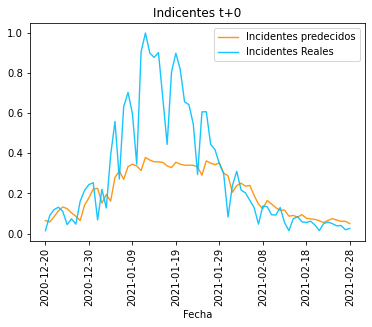

In [20]:
grafica(y_pred, y_test_3, -1)

In [21]:
CCs_test_lag3_rf.append(round(np.corrcoef(y_test_3, y_pred)[0][1],3))

### Predicción 7 días adelante

In [22]:
predicciones_rf_lag3 = calcular_predicciones_lag3(optimised_rf_lag3, y_pred, X_test_3)

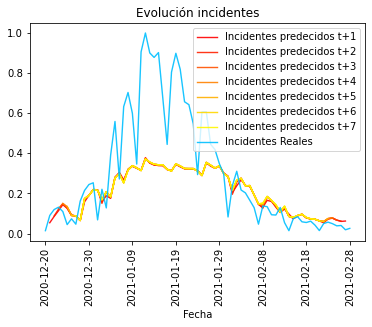

In [23]:
visualizar_predicciones(y_test_3, predicciones_rf_lag3)

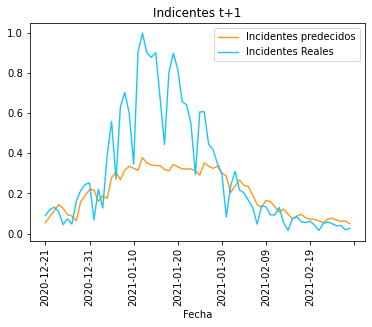

Mean absolute error = 0.15
RMSE = 0.23


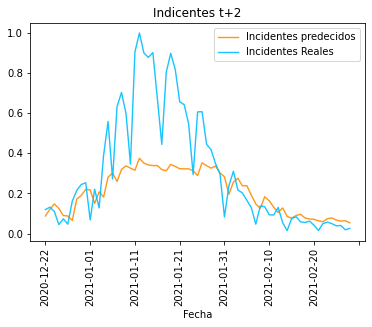

Mean absolute error = 0.15
RMSE = 0.23


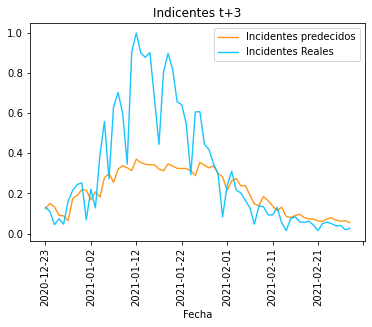

Mean absolute error = 0.15
RMSE = 0.23


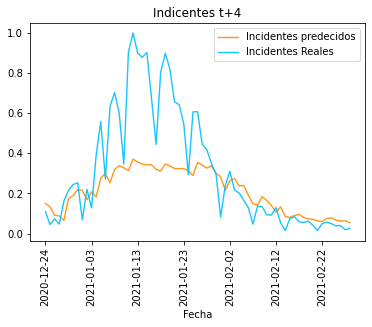

Mean absolute error = 0.15
RMSE = 0.23


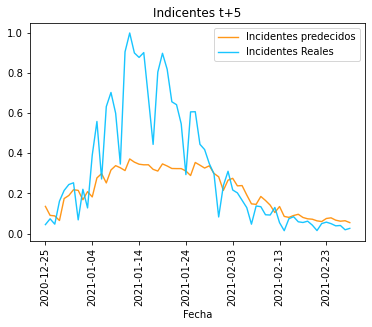

Mean absolute error = 0.15
RMSE = 0.23


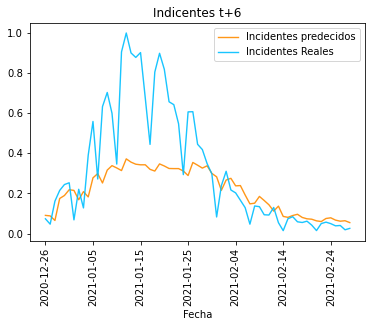

Mean absolute error = 0.15
RMSE = 0.24


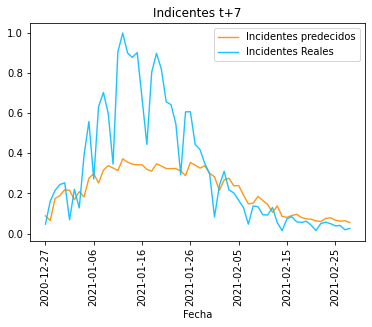

Mean absolute error = 0.16
RMSE = 0.24


In [24]:
MAE_rf, RMSE_rf = graficas_errores(predicciones_rf_lag3, y_test_3)

In [25]:
for i in range(0, len(RMSE_rf)):
    RMSEs_test_lag3_rf.append(RMSE_rf[i])
    MAEs_test_lag3_rf.append(MAE_rf[i])

In [26]:
calcular_cc(y_test_3, predicciones_rf_lag3, CCs_test_lag3_rf)

## Lag 5

### Predicción t

In [169]:
clf_rf = search_grid(rf, grid, X_train_5, y_train_5)

In [170]:
optimised_rf = clf_rf.best_estimator_

In [171]:
clf_rf.best_params_

{'bootstrap': True,
 'max_depth': 20,
 'max_features': 5,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 100}

In [172]:
rf_results = pd.DataFrame(clf_rf.cv_results_)
rf_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.238150      0.032929         0.015190        0.000892   
1       0.714150      0.050421         0.033534        0.007744   
2       1.208178      0.081138         0.063989        0.010854   

  param_bootstrap param_max_depth param_max_features param_min_samples_leaf  \
0            True              20                  2                      1   
1            True              20                  2                      1   
2            True              20                  2                      1   

  param_min_samples_split param_n_estimators  ... split2_train_score  \
0                       4                100  ...          -0.002989   
1                       4                300  ...          -0.002869   
2                       4                500  ...          -0.002908   

   split3_train_score  split4_train_score  split5_train_score  \
0           -0.002695           -0.002551           -0.003324   
1           -0.002493           -0.002467           -0.003173   
2           -0.002511           -0.002490           -0.003147   

   split6_train_score  split7_train_score  split8_train_score  \
0           -0.006114           -0.008909           -0.012888   
1           -0.005845           -0.008784           -0.012696   
2           -0.005818           -0.009112           -0.012635   

   split9_train_score  mean_train_score  std_train_score  
0           -0.017250         -0.006460         0.004775  
1           -0.017192         -0.006311         0.004789  
2           -0.017075         -0.006328         0.004769  

[3 rows x 36 columns]

In [173]:
joblib.dump(optimised_rf, 'rf_lag5_escalado.pkl')

['rf_lag5_escalado.pkl']

In [27]:
optimised_rf_lag5 = joblib.load('rf_lag5_escalado.pkl')

In [28]:
y_pred = optimised_rf_lag5.predict(X_test_5)

In [29]:
RMSEs_test_lag5_rf = []
MAEs_test_lag5_rf = []
CCs_test_lag5_rf = []

RMSEs_test_lag5_rf.append(RMSE(y_pred, y_test_5))
MAEs_test_lag5_rf.append(MAE(y_pred, y_test_5))

RMSE = 0.23
Mean absolute error = 0.14


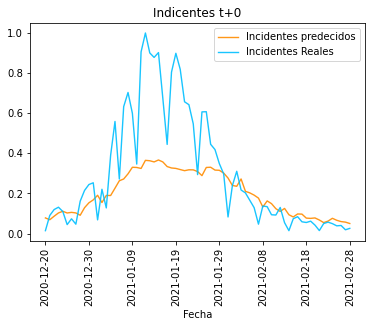

In [28]:
grafica(y_pred, y_test_5, -1)

In [30]:
CCs_test_lag5_rf.append(round(np.corrcoef(y_test_5, y_pred)[0][1],3))

### Predicción 7 días adelante

In [31]:
predicciones_rf_lag5 = calcular_predicciones_lag5(optimised_rf_lag5, y_pred, X_test_5)

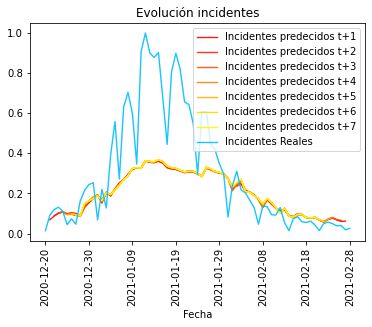

In [31]:
visualizar_predicciones(y_test_5, predicciones_rf_lag5)

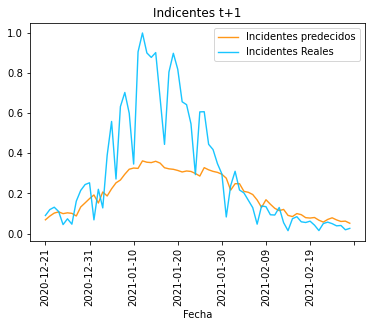

Mean absolute error = 0.15
RMSE = 0.23


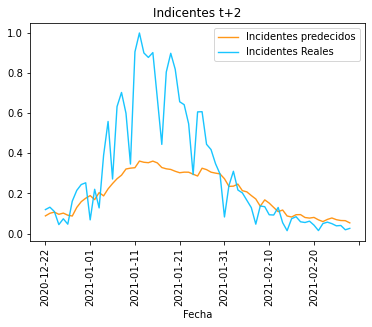

Mean absolute error = 0.15
RMSE = 0.23


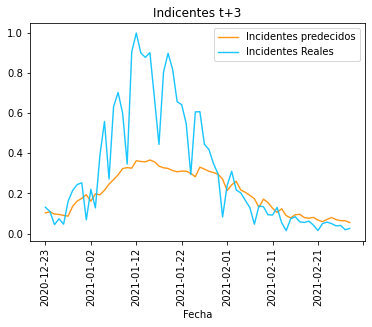

Mean absolute error = 0.15
RMSE = 0.23


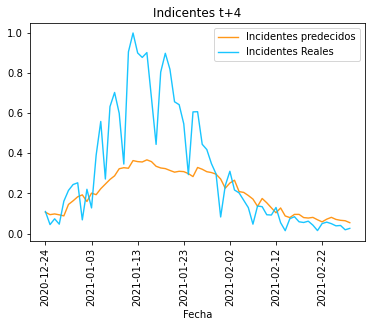

Mean absolute error = 0.15
RMSE = 0.23


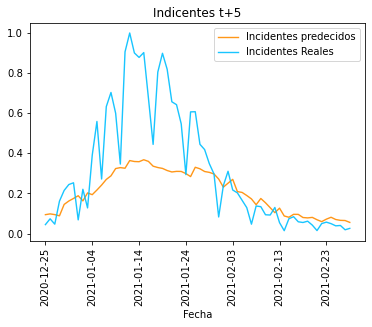

Mean absolute error = 0.15
RMSE = 0.24


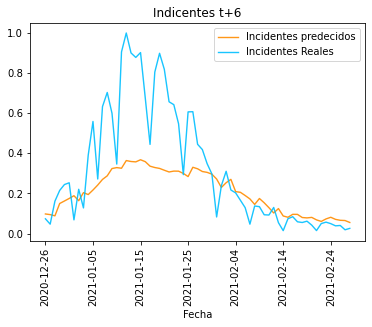

Mean absolute error = 0.16
RMSE = 0.24


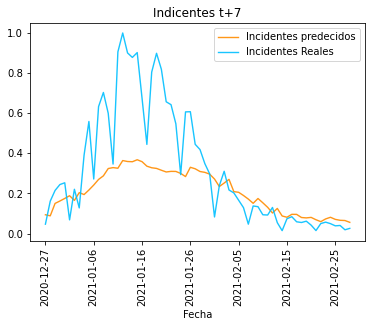

Mean absolute error = 0.16
RMSE = 0.24


In [32]:
MAE_rf, RMSE_rf = graficas_errores(predicciones_rf_lag5, y_test_5)

In [33]:
for i in range(0, len(RMSE_rf)):
    RMSEs_test_lag5_rf.append(RMSE_rf[i])
    MAEs_test_lag5_rf.append(MAE_rf[i])

In [34]:
calcular_cc(y_test_5, predicciones_rf_lag5, CCs_test_lag5_rf)

# Linear Regression

In [15]:
regresion_lineal = LinearRegression()

## Lag 3

### Predicción t

In [16]:
regresion_lineal.fit(X_train_3, y_train_3)

LinearRegression()

In [17]:
joblib.dump(regresion_lineal, 'regresion_lineal_lag3_escalado.pkl')

['regresion_lineal_lag3_escalado.pkl']

In [35]:
regresion_lineal_lag3 = joblib.load('regresion_lineal_lag3_escalado.pkl')

In [36]:
y_pred = regresion_lineal_lag3.predict(X_test_3)

In [37]:
RMSEs_test_lag3_LR = []
MAEs_test_lag3_LR = []
CCs_test_lag3_LR = []

RMSEs_test_lag3_LR.append(RMSE(y_pred, y_test_3))
MAEs_test_lag3_LR.append(MAE(y_pred, y_test_3))

RMSE = 0.13
Mean absolute error = 0.09


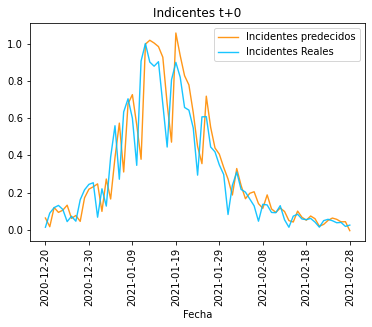

In [37]:
grafica(y_pred, y_test_3, -1)

In [38]:
CCs_test_lag3_LR.append(round(np.corrcoef(y_test_3, y_pred)[0][1],3))

### Predicción 7 días adelante

Creamos una lista donde irán las predicciones t+i con i = 1,...,7

In [39]:
predicciones_LR_lag3 = calcular_predicciones_lag3(regresion_lineal_lag3, y_pred, X_test_3)

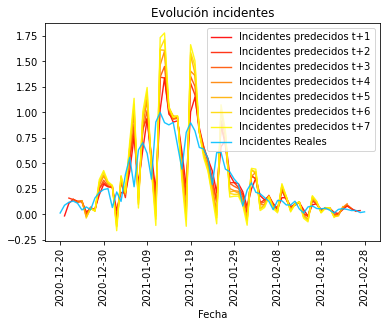

In [40]:
visualizar_predicciones(y_test_3, predicciones_LR_lag3)

Calculamos las gráficas de las predicciones así como los errores

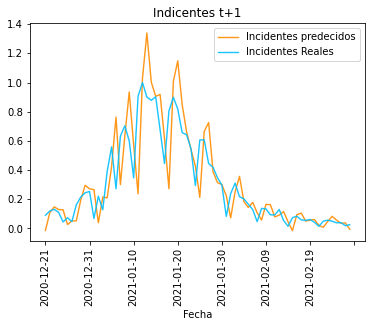

Mean absolute error = 0.11
RMSE = 0.18


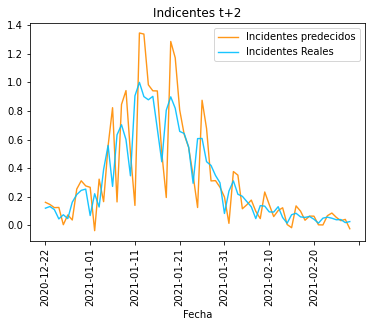

Mean absolute error = 0.14
RMSE = 0.21


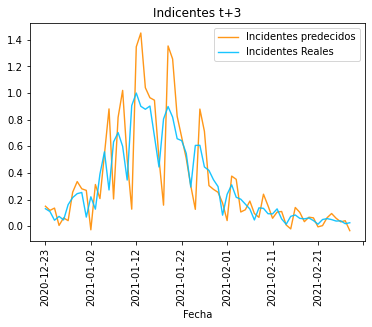

Mean absolute error = 0.15
RMSE = 0.23


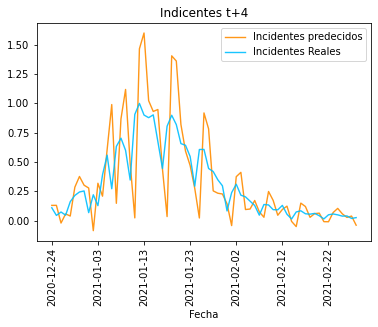

Mean absolute error = 0.17
RMSE = 0.27


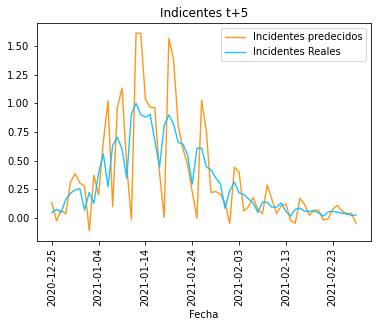

Mean absolute error = 0.19
RMSE = 0.3


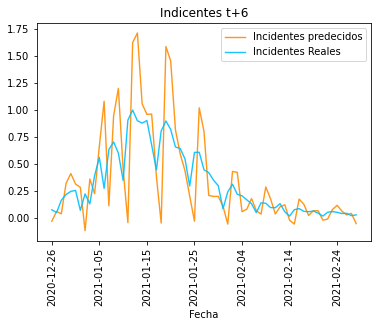

Mean absolute error = 0.21
RMSE = 0.32


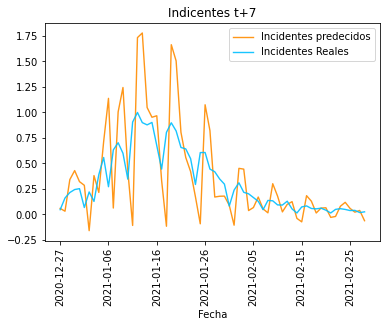

Mean absolute error = 0.23
RMSE = 0.35


In [40]:
MAE_LR, RMSE_LR = graficas_errores(predicciones_LR_lag3, y_test_3)

In [41]:
for i in range(0, len(RMSE_LR)):
    RMSEs_test_lag3_LR.append(RMSE_LR[i])
    MAEs_test_lag3_LR.append(MAE_LR[i])

In [42]:
calcular_cc(y_test_3, predicciones_rf_lag3, CCs_test_lag3_rf)

## Lag 5

In [31]:
regresion_lineal.fit(X_train_5, y_train_5)

LinearRegression()

In [32]:
joblib.dump(regresion_lineal, 'regresion_lineal_lag5_escalado.pkl')

['regresion_lineal_lag5_escalado.pkl']

In [43]:
regresion_lineal_lag5 = joblib.load('regresion_lineal_lag5_escalado.pkl')

### Predicción t

In [44]:
y_pred = regresion_lineal_lag5.predict(X_test_5)

In [45]:
RMSEs_test_lag5_LR = []
MAEs_test_lag5_LR = []
CCs_test_lag5_LR = []

RMSEs_test_lag5_LR.append(RMSE(y_pred, y_test_5))
MAEs_test_lag5_LR.append(MAE(y_pred, y_test_5))

RMSE = 0.13
Mean absolute error = 0.08


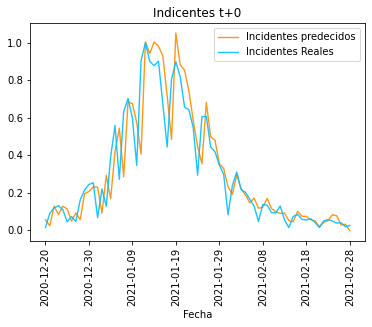

In [46]:
grafica(y_pred, y_test_5, -1)

In [47]:
CCs_test_lag5_LR.append(round(np.corrcoef(y_test_5, y_pred)[0][1],3))

### Predicción 7 días adelante

In [48]:
predicciones_LR_lag5 = calcular_predicciones_lag5(regresion_lineal_lag5, y_pred, X_test_5)

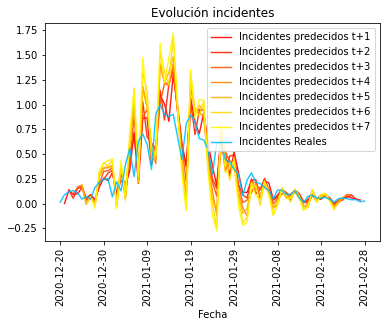

In [48]:
visualizar_predicciones(y_test_5, predicciones_LR_lag5)

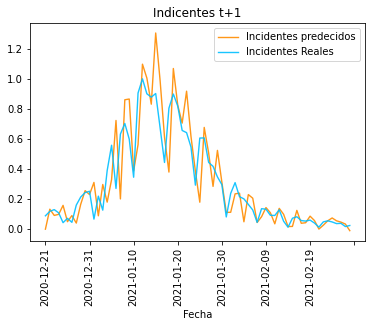

Mean absolute error = 0.11
RMSE = 0.16


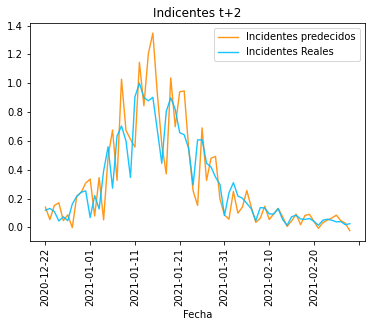

Mean absolute error = 0.12
RMSE = 0.17


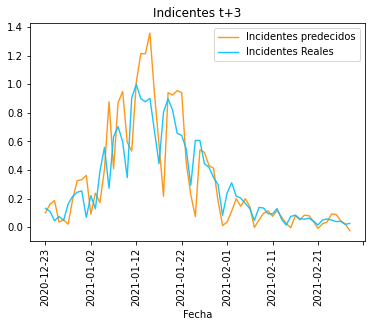

Mean absolute error = 0.13
RMSE = 0.19


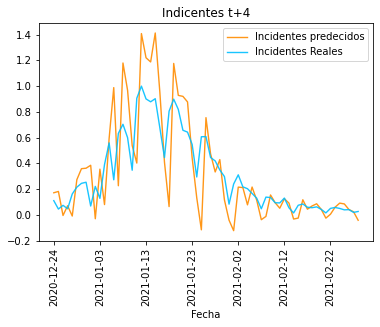

Mean absolute error = 0.17
RMSE = 0.25


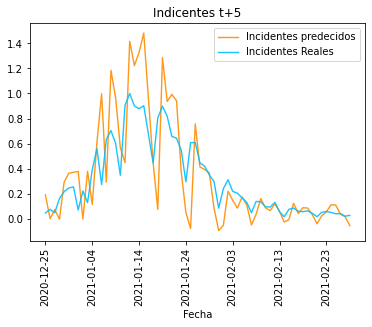

Mean absolute error = 0.17
RMSE = 0.25


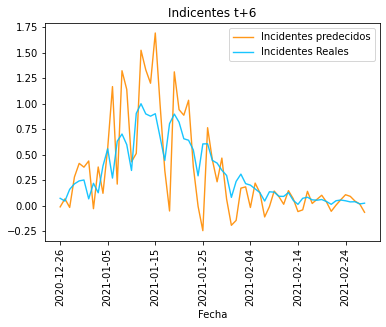

Mean absolute error = 0.21
RMSE = 0.3


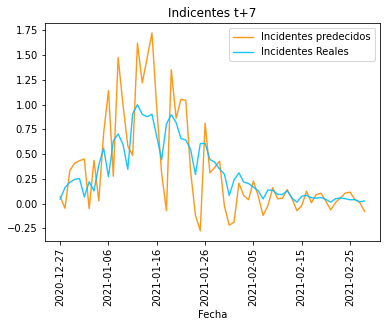

Mean absolute error = 0.23
RMSE = 0.33


In [49]:
MAE_LR, RMSE_LR = graficas_errores(predicciones_LR_lag5, y_test_5)

In [50]:
for i in range(0, len(RMSE_LR)):
    RMSEs_test_lag5_LR.append(RMSE_LR[i])
    MAEs_test_lag5_LR.append(MAE_LR[i])

In [51]:
calcular_cc(y_test_5, predicciones_LR_lag5, CCs_test_lag5_LR)

# SVR 

In [121]:
svr = svm.SVR()

In [122]:
svr.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

- Kernel
    - Lineal: OK
    - Polinomial: OK
    - Radial: kernel gaussiano, OK
    - Sigmoid: OK
- Epsilon
- Degree: es el grado del polinomio
- 0.1 < c < 100

In [123]:
grid = {'C' : [0.25, 0.5, 1, 2, 4, 8, 16, 32],
        #'C' : [0.001, 0.01, 0.1, 1],
        'epsilon' : [0.1, 0.01, 0.05],
        'gamma' : ['auto'],
        'degree' : [2,3,4],
        'kernel' : ['sigmoid', 'linear', 'poly'],
        'coef0' : [0.0, 0.01, 0.05, 0.1]} 

In [125]:
clf_svr = search_grid(svr, grid, X_train_3, y_train_3)

In [127]:
clf_svr.best_params_

{'C': 32,
 'coef0': 0.0,
 'degree': 2,
 'epsilon': 0.01,
 'gamma': 'auto',
 'kernel': 'linear'}

In [130]:
svr_results = pd.DataFrame(clf_svr.cv_results_)
svr_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.004388      0.001111         0.003491        0.002241    0.25   
1       0.004787      0.002742         0.007481        0.008582    0.25   
2       0.003989      0.000892         0.006084        0.006517    0.25   

  param_coef0 param_degree param_epsilon param_gamma param_kernel  ...  \
0           0            2           0.1        auto      sigmoid  ...   
1           0            2           0.1        auto       linear  ...   
2           0            2           0.1        auto         poly  ...   

  split2_train_score  split3_train_score  split4_train_score  \
0          -0.020984           -0.021895           -0.021811   
1          -0.020984           -0.021895           -0.021811   
2          -0.020984           -0.021895           -0.021811   

   split5_train_score  split6_train_score  split7_train_score  \
0           -0.027055           -0.086278           -0.084233   
1           -0.027055           -0.085420           -0.070687   
2           -0.027055           -0.086582           -0.088656   

   split8_train_score  split9_train_score  mean_train_score  std_train_score  
0           -0.079713           -0.081937         -0.045886         0.030491  
1           -0.040356           -0.057981         -0.038114         0.023457  
2           -0.097484           -0.098198         -0.049762         0.035335  

[3 rows x 36 columns]

## Lag 3

### Predicción t

In [126]:
optimised_svr = clf_svr.best_estimator_

In [128]:
joblib.dump(optimised_svr, 'svr_lag3_escalado.pkl')

['svr_lag3_escalado.pkl']

In [52]:
optimised_svr_lag3 = joblib.load('svr_lag3_escalado.pkl')

In [53]:
y_pred = optimised_svr_lag3.predict(X_test_3)

In [54]:
RMSEs_test_lag3_SVR = []
MAEs_test_lag3_SVR = []
CCs_test_lag3_SVR = []

RMSEs_test_lag3_SVR.append(RMSE(y_pred, y_test_3))
MAEs_test_lag3_SVR.append(MAE(y_pred, y_test_3))

RMSE = 0.13
Mean absolute error = 0.09


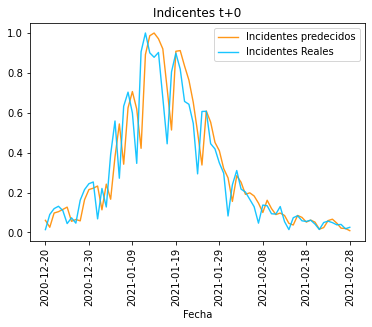

In [134]:
grafica(y_pred, y_test_3, -1)

In [55]:
CCs_test_lag3_SVR.append(round(np.corrcoef(y_test_3, y_pred)[0][1],3))

### Predicción 7 días adelante

In [56]:
predicciones_svr_lag3 = calcular_predicciones_lag3(optimised_svr_lag3, y_pred, X_test_3)

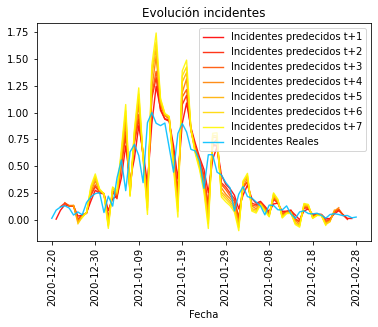

In [54]:
visualizar_predicciones(y_test_3, predicciones_svr_lag3)

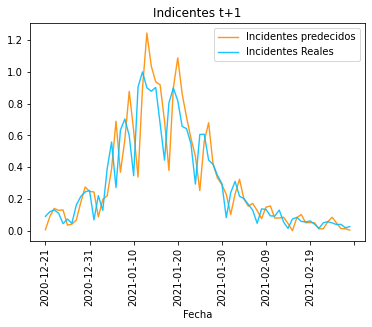

Mean absolute error = 0.1
RMSE = 0.16


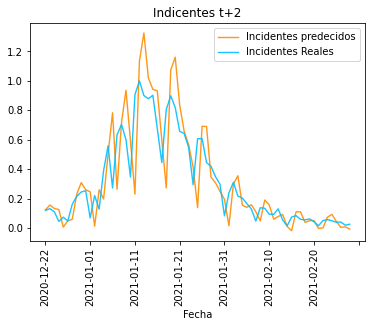

Mean absolute error = 0.12
RMSE = 0.19


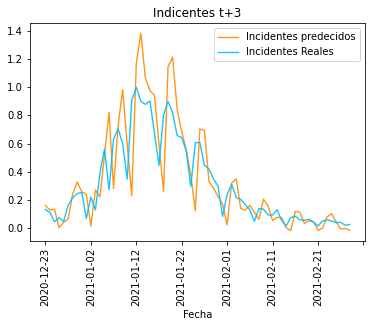

Mean absolute error = 0.13
RMSE = 0.2


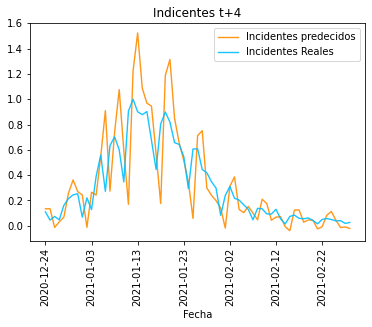

Mean absolute error = 0.15
RMSE = 0.23


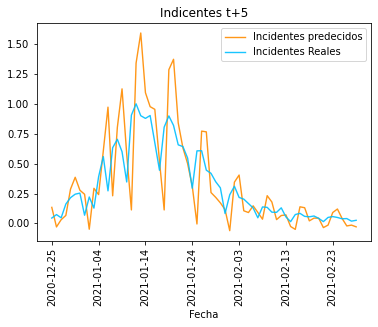

Mean absolute error = 0.17
RMSE = 0.26


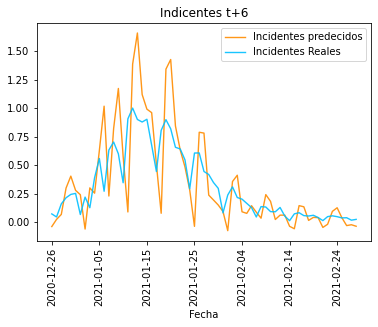

Mean absolute error = 0.18
RMSE = 0.27


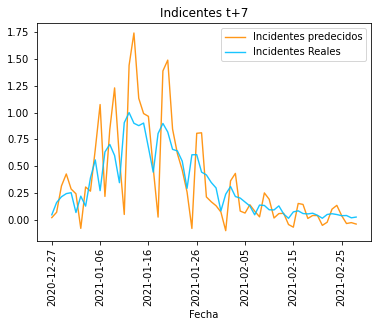

Mean absolute error = 0.2
RMSE = 0.3


In [57]:
MAE_SVR, RMSE_SVR = graficas_errores(predicciones_svr_lag3, y_test_3)

In [58]:
for i in range(0, len(RMSE_SVR)):
    RMSEs_test_lag3_SVR.append(RMSE_SVR[i])
    MAEs_test_lag3_SVR.append(MAE_SVR[i])

In [59]:
calcular_cc(y_test_3, predicciones_svr_lag3, CCs_test_lag3_SVR)

## Lag 5

### Predicción t

In [138]:
clf_svr = search_grid(svr, grid, X_train_5, y_train_5)

In [139]:
clf_svr.best_params_

{'C': 16,
 'coef0': 0.0,
 'degree': 2,
 'epsilon': 0.01,
 'gamma': 'auto',
 'kernel': 'linear'}

In [140]:
svr_results = pd.DataFrame(clf_svr.cv_results_)
svr_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.006470      0.004916         0.003191    3.989541e-04    0.25   
1       0.005087      0.001509         0.006483    6.529154e-03    0.25   
2       0.007779      0.008186         0.002992    9.419797e-07    0.25   

  param_coef0 param_degree param_epsilon param_gamma param_kernel  ...  \
0           0            2           0.1        auto      sigmoid  ...   
1           0            2           0.1        auto       linear  ...   
2           0            2           0.1        auto         poly  ...   

  split2_train_score  split3_train_score  split4_train_score  \
0          -0.020972           -0.021903           -0.021816   
1          -0.020972           -0.021903           -0.021816   
2          -0.020972           -0.021903           -0.021816   

   split5_train_score  split6_train_score  split7_train_score  \
0            -0.02703           -0.086462           -0.084307   
1            -0.02703           -0.086055           -0.075169   
2            -0.02703           -0.086306           -0.088386   

   split8_train_score  split9_train_score  mean_train_score  std_train_score  
0           -0.081021           -0.083449         -0.046131         0.030912  
1           -0.040656           -0.056998         -0.038495         0.024216  
2           -0.098377           -0.098862         -0.049800         0.035548  

[3 rows x 36 columns]

In [141]:
optimised_svr = clf_svr.best_estimator_

In [142]:
joblib.dump(optimised_svr, 'svr_lag5_escalado.pkl')

['svr_lag5_escalado.pkl']

In [60]:
optimised_svr_lag5 = joblib.load('svr_lag5_escalado.pkl')

In [61]:
y_pred = optimised_svr_lag5.predict(X_test_5)

In [62]:
RMSEs_test_lag5_SVR = []
MAEs_test_lag5_SVR = []
CCs_test_lag5_SVR = []

RMSEs_test_lag5_SVR.append(RMSE(y_pred, y_test_5))
MAEs_test_lag5_SVR.append(MAE(y_pred, y_test_5))

RMSE = 0.13
Mean absolute error = 0.08


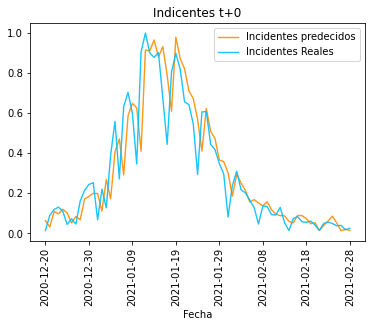

In [147]:
grafica(y_pred, y_test_5, -1)

In [63]:
CCs_test_lag5_SVR.append(round(np.corrcoef(y_test_5, y_pred)[0][1],3))

### Predicción 7 días adelante

In [65]:
predicciones_svr_lag5 = calcular_predicciones_lag5(optimised_svr_lag5, y_pred, X_test_5)

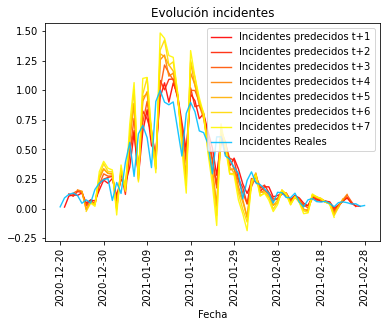

In [66]:
visualizar_predicciones(y_test_5, predicciones_svr_lag5)

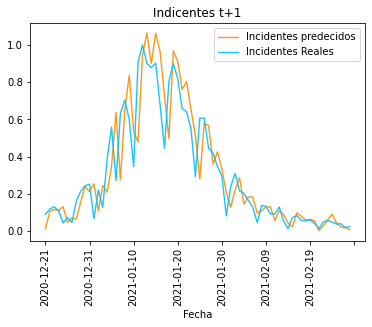

Mean absolute error = 0.09
RMSE = 0.14


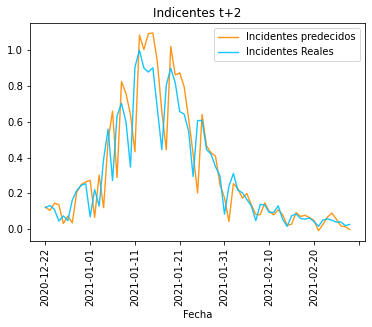

Mean absolute error = 0.1
RMSE = 0.15


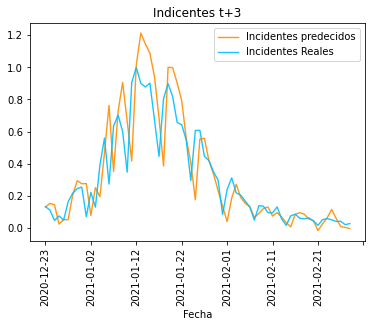

Mean absolute error = 0.11
RMSE = 0.17


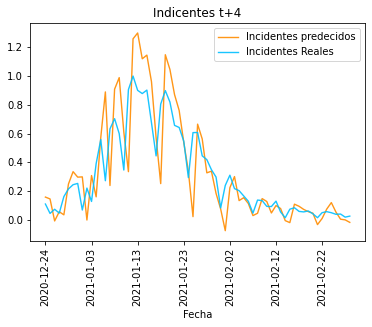

Mean absolute error = 0.14
RMSE = 0.21


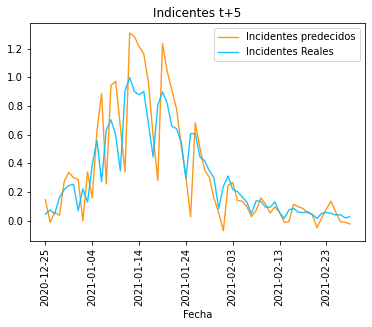

Mean absolute error = 0.14
RMSE = 0.21


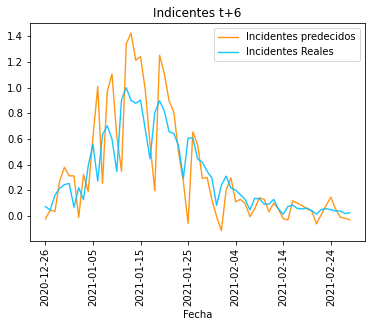

Mean absolute error = 0.16
RMSE = 0.24


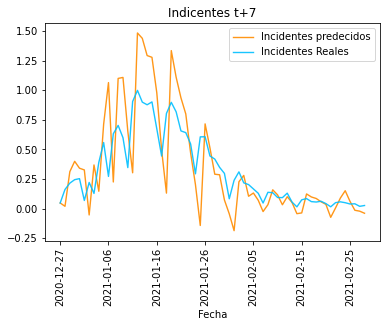

Mean absolute error = 0.19
RMSE = 0.27


In [67]:
MAE_SVR, RMSE_SVR = graficas_errores(predicciones_svr_lag5, y_test_5)

In [68]:
for i in range(0, len(RMSE_SVR)):
    RMSEs_test_lag5_SVR.append(RMSE_SVR[i])
    MAEs_test_lag5_SVR.append(MAE_SVR[i])

In [69]:
calcular_cc(y_test_5, predicciones_svr_lag5, CCs_test_lag5_SVR)

# Lasso

In [43]:
lasso = Lasso(random_state = 42)

(1 / (2 * n_samples)) * ||y - Xw||^2_2 + alpha * ||w||_1

In [148]:
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': False,
 'positive': False,
 'precompute': False,
 'random_state': 42,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

- Alpha: es el coeficiente que multiplica al factor de regularización L1 (por defecto es 1)
- Max_iter: número máximo de iteraciones (por defecto está a 1000)
- Tol: tolerancia en la optimización (por defecto es 0.0001)

In [44]:
grid = {#'alpha' : [0.9, 1, 1.1, 1.2, 1.3, 1.5],
        'alpha': np.logspace(-10, 3, 200),
        'max_iter' : [1000, 3000, 5000, 7000, 10000],
        'tol' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]}

## Lag 3

### Predicción t

In [45]:
clf_lasso = search_grid(lasso, grid, X_train_3, y_train_3)

In [46]:
clf_lasso.best_params_

{'alpha': 2.768286630392067e-06, 'max_iter': 3000, 'tol': 0.001}

In [47]:
lasso_results = pd.DataFrame(clf_lasso.cv_results_)#.sort_values(by = ['rank_test_score'])
#lasso_results.head(3)
#lasso_results[
#    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]
lasso_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.013264      0.001003         0.003292        0.000458       1e-10   
1       0.013962      0.001945         0.003890        0.001509       1e-10   
2       0.015558      0.003065         0.003590        0.001111       1e-10   

  param_max_iter param_tol                                             params  \
0           1000    0.0001  {'alpha': 1e-10, 'max_iter': 1000, 'tol': 0.0001}   
1           1000     0.001   {'alpha': 1e-10, 'max_iter': 1000, 'tol': 0.001}   
2           1000      0.01    {'alpha': 1e-10, 'max_iter': 1000, 'tol': 0.01}   

   split0_test_score  split1_test_score  ...  split2_train_score  \
0          -0.017193          -0.005675  ...           -0.003463   
1          -0.017193          -0.005675  ...           -0.003463   
2          -0.017193          -0.005675  ...           -0.003463   

   split3_train_score  split4_train_score  split5_train_score  \
0            -0.00318           -0.003783           -0.006043   
1            -0.00318           -0.003783           -0.006043   
2            -0.00318           -0.003783           -0.006043   

   split6_train_score  split7_train_score  split8_train_score  \
0            -0.01041           -0.017316           -0.023809   
1            -0.01041           -0.017316           -0.023809   
2            -0.01041           -0.017316           -0.023809   

   split9_train_score  mean_train_score  std_train_score  
0           -0.031761         -0.010616         0.009749  
1           -0.031761         -0.010616         0.009749  
2           -0.031761         -0.010616         0.009749  

[3 rows x 33 columns]

In [48]:
optimised_lasso = clf_lasso.best_estimator_

In [49]:
joblib.dump(optimised_lasso, 'lasso_lag3_escalado.pkl')

['lasso_lag3_escalado.pkl']

In [70]:
optimised_lasso_lag3 = joblib.load('lasso_lag3_escalado.pkl')

In [71]:
y_pred = optimised_lasso_lag3.predict(X_test_3)

In [72]:
RMSEs_test_lag3_lasso = []
MAEs_test_lag3_lasso = []
CCs_test_lag3_lasso = []

RMSEs_test_lag3_lasso.append(RMSE(y_pred, y_test_3))
MAEs_test_lag3_lasso.append(MAE(y_pred, y_test_3))

RMSE = 0.13
Mean absolute error = 0.09


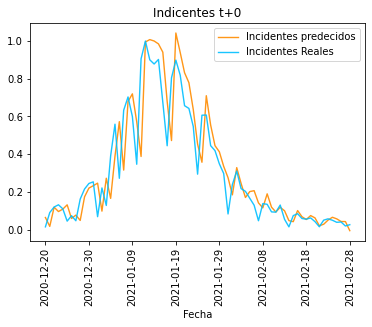

In [54]:
grafica(y_pred, y_test_3, -1)

In [73]:
CCs_test_lag3_lasso.append(round(np.corrcoef(y_test_3, y_pred)[0][1],3))

### Predicción 7 días adelante

In [74]:
predicciones_lasso_lag3 = calcular_predicciones_lag3(optimised_lasso_lag3, y_pred, X_test_3)

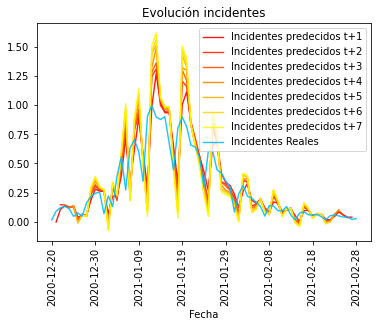

In [66]:
visualizar_predicciones(y_test_3, predicciones_lasso_lag3)

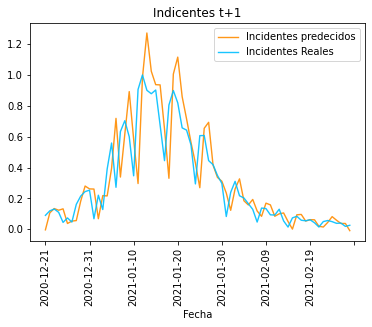

Mean absolute error = 0.1
RMSE = 0.16


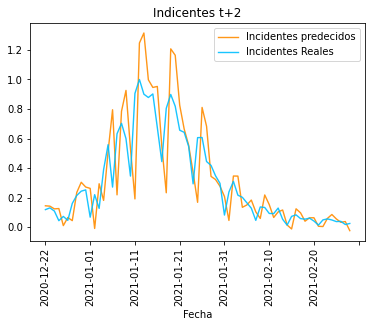

Mean absolute error = 0.13
RMSE = 0.2


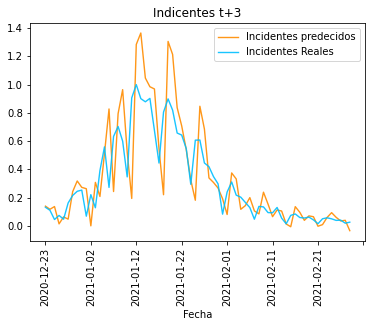

Mean absolute error = 0.13
RMSE = 0.21


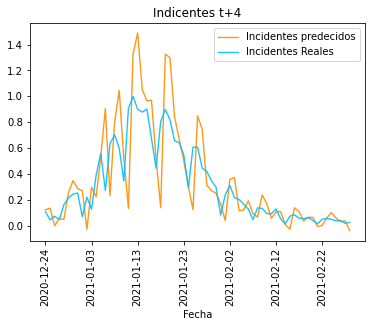

Mean absolute error = 0.15
RMSE = 0.23


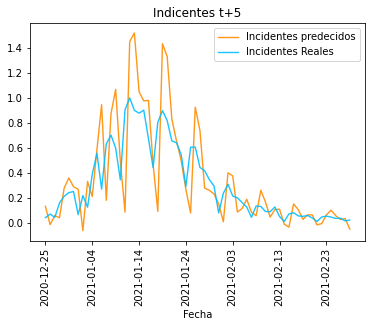

Mean absolute error = 0.17
RMSE = 0.26


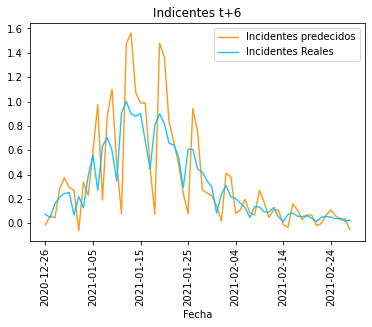

Mean absolute error = 0.17
RMSE = 0.27


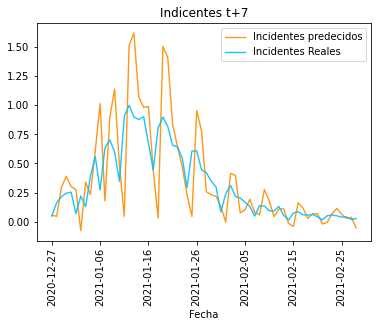

Mean absolute error = 0.19
RMSE = 0.28


In [75]:
MAE_lasso, RMSE_lasso = graficas_errores(predicciones_lasso_lag3, y_test_3)

In [76]:
for i in range(0, len(RMSE_lasso)):
    RMSEs_test_lag3_lasso.append(RMSE_lasso[i])
    MAEs_test_lag3_lasso.append(MAE_lasso[i])

In [77]:
calcular_cc(y_test_3, predicciones_lasso_lag3, CCs_test_lag3_lasso)

## Lag 5

In [62]:
clf_lasso = search_grid(lasso, grid, X_train_5, y_train_5)

In [63]:
clf_lasso.best_params_

{'alpha': 2.768286630392067e-06, 'max_iter': 5000, 'tol': 0.001}

In [64]:
lasso_results = pd.DataFrame(clf_lasso.cv_results_)#.sort_values(by = ['rank_test_score'])
#lasso_results.head(3)
#lasso_results[
#    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']]
lasso_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.025032      0.009633         0.004290        0.001611       1e-10   
1       0.021642      0.004325         0.004389        0.001351       1e-10   
2       0.020645      0.007261         0.002992        0.000446       1e-10   

  param_max_iter param_tol                                             params  \
0           1000    0.0001  {'alpha': 1e-10, 'max_iter': 1000, 'tol': 0.0001}   
1           1000     0.001   {'alpha': 1e-10, 'max_iter': 1000, 'tol': 0.001}   
2           1000      0.01    {'alpha': 1e-10, 'max_iter': 1000, 'tol': 0.01}   

   split0_test_score  split1_test_score  ...  split2_train_score  \
0          -0.024179          -0.007147  ...           -0.002734   
1          -0.024179          -0.007147  ...           -0.002734   
2          -0.018363          -0.007147  ...           -0.002734   

   split3_train_score  split4_train_score  split5_train_score  \
0            -0.00264           -0.003072            -0.00512   
1            -0.00264           -0.003072            -0.00512   
2            -0.00264           -0.003072            -0.00512   

   split6_train_score  split7_train_score  split8_train_score  \
0           -0.008976           -0.014611           -0.021445   
1           -0.008976           -0.014611           -0.021445   
2           -0.008976           -0.014611           -0.021445   

   split9_train_score  mean_train_score  std_train_score  
0           -0.029719         -0.009168         0.009241  
1           -0.029719         -0.009168         0.009241  
2           -0.029719         -0.009258         0.009163  

[3 rows x 33 columns]

In [65]:
optimised_lasso = clf_lasso.best_estimator_

In [66]:
joblib.dump(optimised_lasso, 'lasso_lag5_escalado.pkl')

['lasso_lag5_escalado.pkl']

In [78]:
optimised_lasso_lag5 = joblib.load('lasso_lag5_escalado.pkl')

### Predicción t

In [79]:
y_pred = optimised_lasso_lag5.predict(X_test_5)

In [80]:
RMSEs_test_lag5_lasso = []
MAEs_test_lag5_lasso = []
CCs_test_lag5_lasso = []

RMSEs_test_lag5_lasso.append(RMSE(y_pred, y_test_5))
MAEs_test_lag5_lasso.append(MAE(y_pred, y_test_5))

RMSE = 0.13
Mean absolute error = 0.08


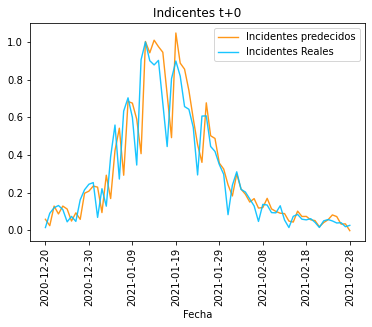

In [71]:
grafica(y_pred, y_test_5, -1)

In [81]:
CCs_test_lag5_lasso.append(round(np.corrcoef(y_test_5, y_pred)[0][1],3))

### Predicción 7 días adelante

In [82]:
predicciones_lasso_lag5 = calcular_predicciones_lag5(optimised_lasso_lag5, y_pred, X_test_5)

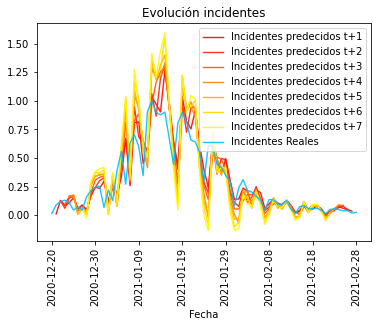

In [72]:
visualizar_predicciones(y_test_5, predicciones_lasso_lag5)

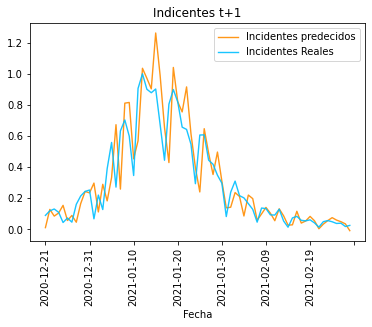

Mean absolute error = 0.09
RMSE = 0.14


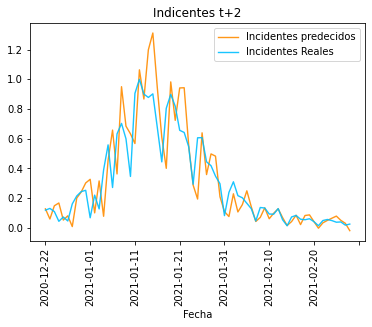

Mean absolute error = 0.11
RMSE = 0.16


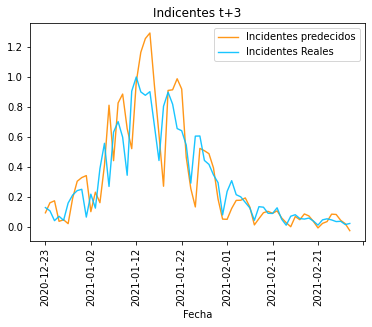

Mean absolute error = 0.12
RMSE = 0.18


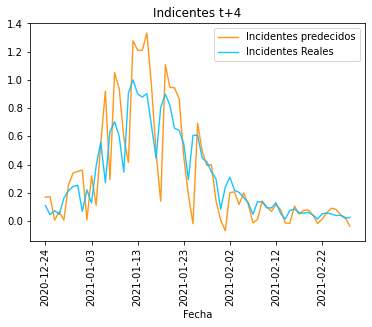

Mean absolute error = 0.15
RMSE = 0.22


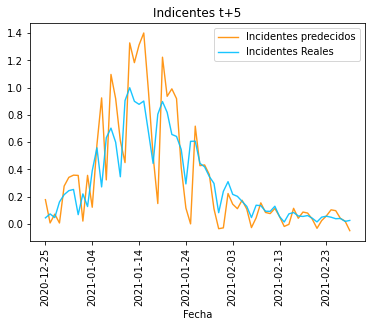

Mean absolute error = 0.16
RMSE = 0.23


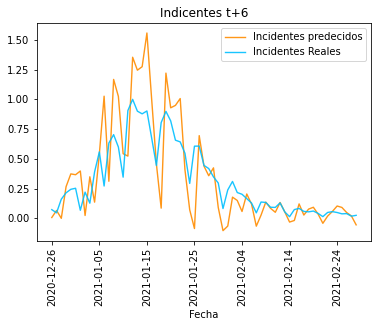

Mean absolute error = 0.17
RMSE = 0.25


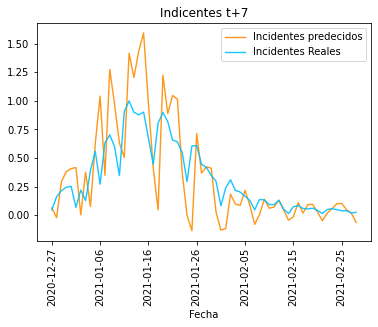

Mean absolute error = 0.19
RMSE = 0.28


In [83]:
MAE_lasso, RMSE_lasso = graficas_errores(predicciones_lasso_lag5, y_test_5)

In [84]:
for i in range(0, len(RMSE_lasso)):
    RMSEs_test_lag5_lasso.append(RMSE_lasso[i])
    MAEs_test_lag5_lasso.append(MAE_lasso[i])

In [85]:
calcular_cc(y_test_5, predicciones_lasso_lag5, CCs_test_lag5_lasso)

# Gradient Boosting Regressor

La idea de este modelo es construir árboles en serie de forma que un árbol posterior intenta corregir los errores de todos
los anteriores. Parámetros importantes son la profundidad de los árboles, cuándo hacer pre-prunning (útil para evitar el overfitting) y también el ratio de aprendizaje o learning_rate que controla como se esfuerza el árbol actual en corregir los errores de los árboles anteriores. También podemos aumentar el número de árboles con el parámetro n_estimators.
Al contrario que en random forest, usar un número de árboles muy alto en gradient llevará a un modelo mucho más complejo que
puede caer en overfitting. Max_depth suele variar entre 1 y 5

In [76]:
# Instancia del modelo
gbr = GradientBoostingRegressor(random_state = 42)

In [122]:
gbr.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [110]:
grid = {'n_estimators':[50, 100, 250, 500], 
        'max_depth':[3, 4, 5, 8, 10], 
        'min_samples_leaf':[4, 8, 10], 
        'max_features':[2, 3, 5]} 

## Lag 3

### Predicción t

In [111]:
clf_gbr = search_grid(gbr, grid, X_train_3, y_train_3)

In [112]:
clf_gbr.best_params_

{'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 4, 'n_estimators': 50}

In [113]:
gbr_results = pd.DataFrame(clf_gbr.cv_results_)
gbr_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.026728      0.003301         0.003591        0.000488   
1       0.048071      0.005330         0.003292        0.000457   
2       0.106315      0.010900         0.003392        0.000489   

  param_max_depth param_max_features param_min_samples_leaf  \
0               3                  2                      4   
1               3                  2                      4   
2               3                  2                      4   

  param_n_estimators                                             params  \
0                 50  {'max_depth': 3, 'max_features': 2, 'min_sampl...   
1                100  {'max_depth': 3, 'max_features': 2, 'min_sampl...   
2                250  {'max_depth': 3, 'max_features': 2, 'min_sampl...   

   split0_test_score  ...  split2_train_score  split3_train_score  \
0          -0.011109  ...           -0.000984           -0.000940   
1          -0.011064  ...           -0.000477           -0.000515   
2          -0.011034  ...           -0.000093           -0.000138   

   split4_train_score  split5_train_score  split6_train_score  \
0           -0.001136           -0.001857           -0.002766   
1           -0.000733           -0.001076           -0.001635   
2           -0.000268           -0.000416           -0.000569   

   split7_train_score  split8_train_score  split9_train_score  \
0           -0.004857           -0.007097           -0.010549   
1           -0.003014           -0.004173           -0.006568   
2           -0.001099           -0.001645           -0.002426   

   mean_train_score  std_train_score  
0         -0.003219         0.003128  
1         -0.001894         0.001972  
2         -0.000677         0.000763  

[3 rows x 34 columns]

In [114]:
optimised_gbr = clf_gbr.best_estimator_

In [82]:
joblib.dump(optimised_gbr, 'gbr_lag3_escalado.pkl')

['gbr_lag3_escalado.pkl']

In [86]:
optimised_gbr_lag3 = joblib.load('gbr_lag3_escalado.pkl')

In [87]:
y_pred = optimised_gbr_lag3.predict(X_test_3)

In [88]:
RMSEs_test_lag3_gbr = []
MAEs_test_lag3_gbr = []
CCs_test_lag3_gbr = []

RMSEs_test_lag3_gbr.append(RMSE(y_pred, y_test_3))
MAEs_test_lag3_gbr.append(MAE(y_pred, y_test_3))

RMSE = 0.21
Mean absolute error = 0.13


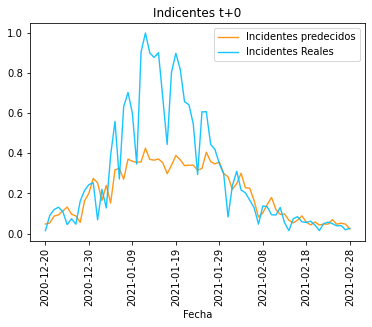

In [118]:
grafica(y_pred, y_test_3, -1)

In [89]:
CCs_test_lag3_gbr.append(round(np.corrcoef(y_test_3, y_pred)[0][1],3))

### Predicción 7 días adelante

In [90]:
predicciones_gbr_lag3 = calcular_predicciones_lag3(optimised_gbr_lag3, y_pred, X_test_3)

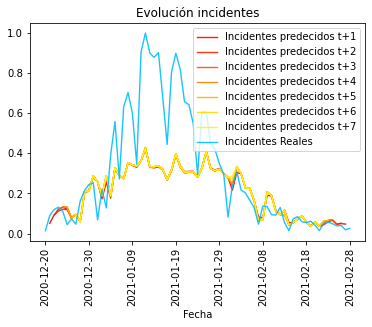

In [78]:
visualizar_predicciones(y_test_3, predicciones_gbr_lag3)

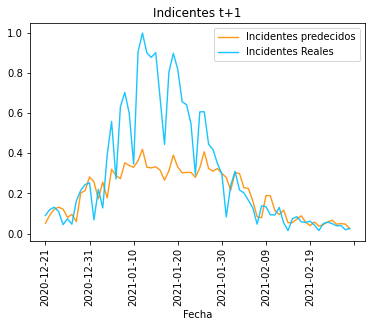

Mean absolute error = 0.14
RMSE = 0.22


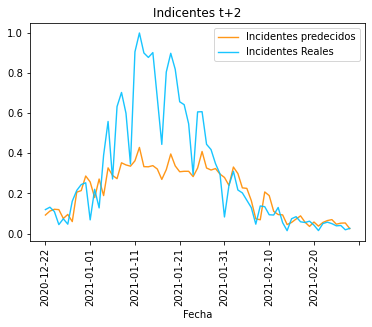

Mean absolute error = 0.14
RMSE = 0.22


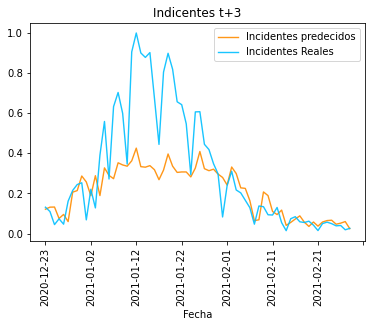

Mean absolute error = 0.14
RMSE = 0.23


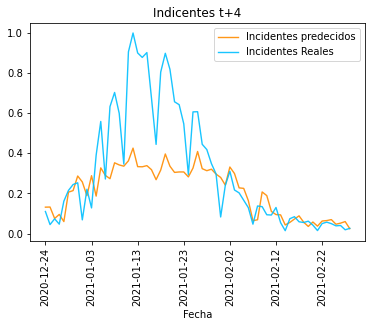

Mean absolute error = 0.14
RMSE = 0.23


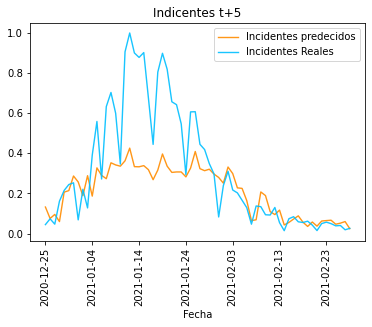

Mean absolute error = 0.15
RMSE = 0.23


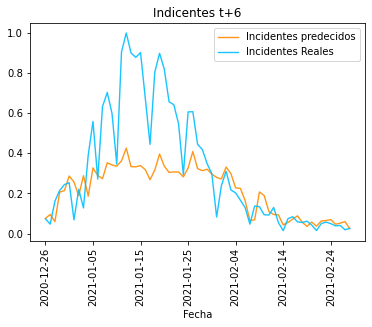

Mean absolute error = 0.15
RMSE = 0.23


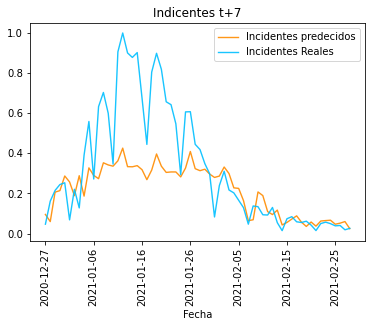

Mean absolute error = 0.15
RMSE = 0.23


In [91]:
MAE_gbr, RMSE_gbr = graficas_errores(predicciones_gbr_lag3, y_test_3)

In [92]:
for i in range(0, len(RMSE_gbr)):
    RMSEs_test_lag3_gbr.append(RMSE_gbr[i])
    MAEs_test_lag3_gbr.append(MAE_gbr[i])

In [93]:
calcular_cc(y_test_3, predicciones_gbr_lag3, CCs_test_lag3_gbr)

## Lag 5

### Predicción t

In [94]:
clf_gbr = search_grid(gbr, grid, X_train_5, y_train_5)

In [95]:
clf_gbr.best_params_

{'max_depth': 10,
 'max_features': 5,
 'min_samples_leaf': 10,
 'n_estimators': 50}

In [96]:
gbr_results = pd.DataFrame(clf_gbr.cv_results_)
gbr_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.027028      0.004645         0.003990        0.001728   
1       0.053158      0.005951         0.003590        0.000489   
2       0.106315      0.012427         0.003591        0.000662   

  param_max_depth param_max_features param_min_samples_leaf  \
0               3                  2                      4   
1               3                  2                      4   
2               3                  2                      4   

  param_n_estimators                                             params  \
0                 50  {'max_depth': 3, 'max_features': 2, 'min_sampl...   
1                100  {'max_depth': 3, 'max_features': 2, 'min_sampl...   
2                250  {'max_depth': 3, 'max_features': 2, 'min_sampl...   

   split0_test_score  ...  split2_train_score  split3_train_score  \
0          -0.014645  ...           -0.001422           -0.001333   
1          -0.014442  ...           -0.000582           -0.000663   
2          -0.014455  ...           -0.000112           -0.000146   

   split4_train_score  split5_train_score  split6_train_score  \
0           -0.001570           -0.002522           -0.004138   
1           -0.000868           -0.001410           -0.002275   
2           -0.000245           -0.000469           -0.000746   

   split7_train_score  split8_train_score  split9_train_score  \
0           -0.008360           -0.012606           -0.017716   
1           -0.004778           -0.007014           -0.010757   
2           -0.001507           -0.002315           -0.003828   

   mean_train_score  std_train_score  
0         -0.005256         0.005480  
1         -0.002930         0.003332  
2         -0.000947         0.001191  

[3 rows x 34 columns]

In [97]:
optimised_gbr = clf_gbr.best_estimator_

In [98]:
joblib.dump(optimised_gbr, 'gbr_lag5_escalado.pkl')

['gbr_lag5_escalado.pkl']

In [94]:
optimised_gbr_lag5 = joblib.load('gbr_lag5_escalado.pkl')

In [95]:
y_pred = optimised_gbr_lag5.predict(X_test_5)

In [96]:
RMSEs_test_lag5_gbr = []
MAEs_test_lag5_gbr = []
CCs_test_lag5_gbr = []

RMSEs_test_lag5_gbr.append(RMSE(y_pred, y_test_5))
MAEs_test_lag5_gbr.append(MAE(y_pred, y_test_5))

RMSE = 0.21
Mean absolute error = 0.13


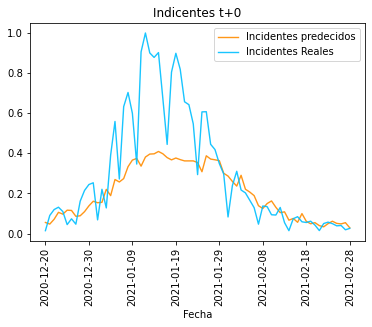

In [103]:
grafica(y_pred, y_test_5, -1)

In [97]:
CCs_test_lag5_gbr.append(round(np.corrcoef(y_test_5, y_pred)[0][1],3))

### Predicción 7 días adelante

In [98]:
predicciones_gbr_lag5 = calcular_predicciones_lag5(optimised_gbr_lag5, y_pred, X_test_5)

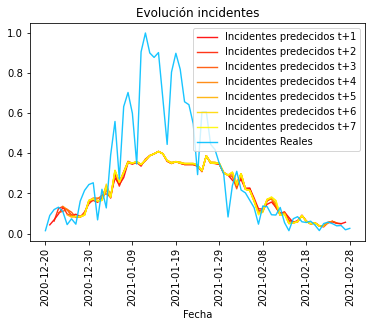

In [84]:
visualizar_predicciones(y_test_5, predicciones_gbr_lag5)

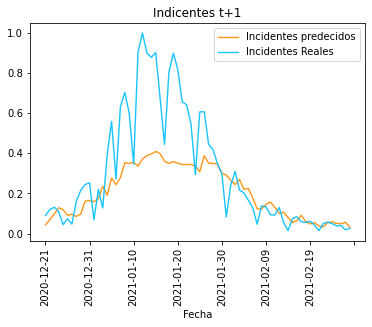

Mean absolute error = 0.14
RMSE = 0.21


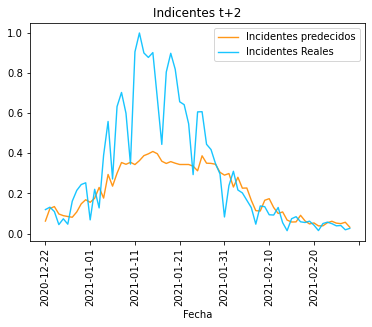

Mean absolute error = 0.14
RMSE = 0.22


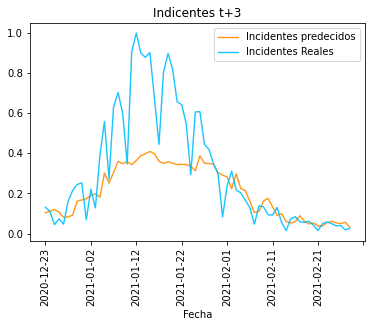

Mean absolute error = 0.14
RMSE = 0.22


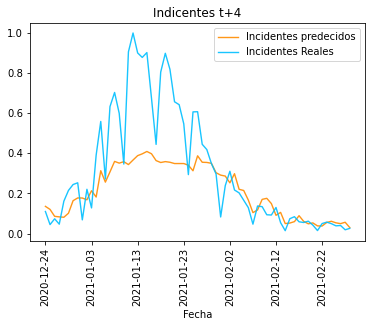

Mean absolute error = 0.14
RMSE = 0.22


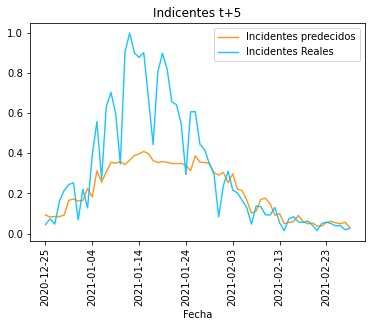

Mean absolute error = 0.14
RMSE = 0.22


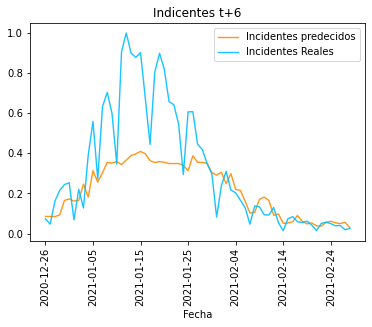

Mean absolute error = 0.14
RMSE = 0.22


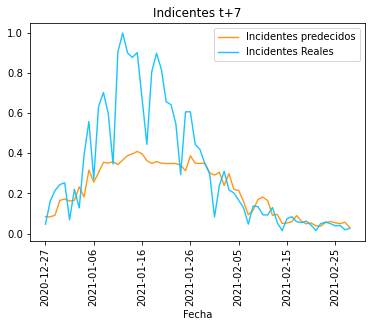

Mean absolute error = 0.14
RMSE = 0.22


In [99]:
MAE_gbr, RMSE_gbr = graficas_errores(predicciones_gbr_lag5, y_test_5)

In [100]:
for i in range(0, len(RMSE_gbr)):
    RMSEs_test_lag5_gbr.append(RMSE_gbr[i])
    MAEs_test_lag5_gbr.append(MAE_gbr[i])

In [101]:
calcular_cc(y_test_5, predicciones_gbr_lag5, CCs_test_lag5_gbr)

# Elastic Net

Minimiza la función objetivo:

1 / (2 * n_samples) * ||y - Xw||^2_2 + alpha * l1_ratio * ||w||_1 + 0.5 * alpha * (1 - l1_ratio) * ||w||^2_2 =

a * ||w||_1 + 0.5 * b * ||w||_2^2 donde

alpha = a + b y l1_ratio = a / (a + b)

In [184]:
elastic_net = ElasticNet(random_state = 42)

In [249]:
grid = {'alpha' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
        'l1_ratio' : np.arange(0, 1, 0.01),
        'max_iter' : [10000,15000,20000],
        'tol' : [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5]}

## Lag 3

In [250]:
clf_en = search_grid(elastic_net, grid, X_train_3, y_train_3)

In [251]:
clf_en.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.17, 'max_iter': 10000, 'tol': 0.001}

In [252]:
en_results = pd.DataFrame(clf_en.cv_results_)
en_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.101225      0.029870         0.003756        0.004432       1e-05   
1       0.088894      0.018066         0.001396        0.001424       1e-05   
2       0.084987      0.022400         0.004686        0.007158       1e-05   

  param_l1_ratio param_max_iter param_tol  \
0              0          10000    0.0001   
1              0          10000     0.001   
2              0          10000      0.01   

                                              params  split0_test_score  ...  \
0  {'alpha': 1e-05, 'l1_ratio': 0.0, 'max_iter': ...          -0.010726  ...   
1  {'alpha': 1e-05, 'l1_ratio': 0.0, 'max_iter': ...          -0.010726  ...   
2  {'alpha': 1e-05, 'l1_ratio': 0.0, 'max_iter': ...          -0.010726  ...   

   split2_train_score  split3_train_score  split4_train_score  \
0           -0.003562           -0.003286           -0.003884   
1           -0.003562           -0.003286           -0.003884   
2           -0.003562           -0.003286           -0.003884   

   split5_train_score  split6_train_score  split7_train_score  \
0           -0.006108           -0.010456           -0.017418   
1           -0.006108           -0.010456           -0.017418   
2           -0.006108           -0.010456           -0.017418   

   split8_train_score  split9_train_score  mean_train_score  std_train_score  
0           -0.023895           -0.031797         -0.010722         0.009718  
1           -0.023895           -0.031797         -0.010722         0.009718  
2           -0.023895           -0.031797         -0.010722         0.009718  

[3 rows x 34 columns]

In [253]:
optimised_en = clf_en.best_estimator_

In [254]:
joblib.dump(optimised_en, 'en_lag3_escalado.pkl')

['en_lag3_escalado.pkl']

In [102]:
optimised_en_lag3 = joblib.load('en_lag3_escalado.pkl')

### Predicción t

In [103]:
y_pred = optimised_en_lag3.predict(X_test_3)

In [104]:
RMSEs_test_lag3_en = []
MAEs_test_lag3_en = []
CCs_test_lag3_en = []

RMSEs_test_lag3_en.append(RMSE(y_pred, y_test_3))
MAEs_test_lag3_en.append(MAE(y_pred, y_test_3))

RMSE = 0.13
Mean absolute error = 0.09


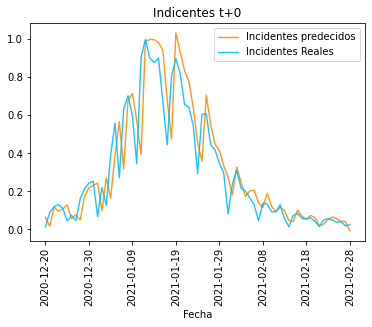

In [259]:
grafica(y_pred, y_test_3, -1)

In [105]:
CCs_test_lag3_gbr.append(round(np.corrcoef(y_test_3, y_pred)[0][1],3))

### Predicción 7 días adelante

In [106]:
predicciones_en_lag3 = calcular_predicciones_lag3(optimised_en_lag3, y_pred, X_test_3)

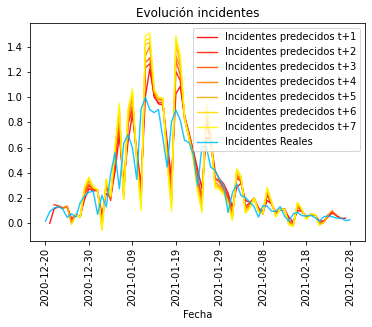

In [90]:
visualizar_predicciones(y_test_3, predicciones_en_lag3)

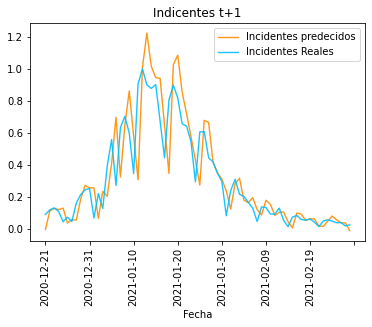

Mean absolute error = 0.1
RMSE = 0.16


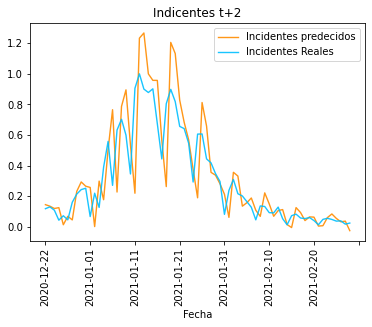

Mean absolute error = 0.12
RMSE = 0.19


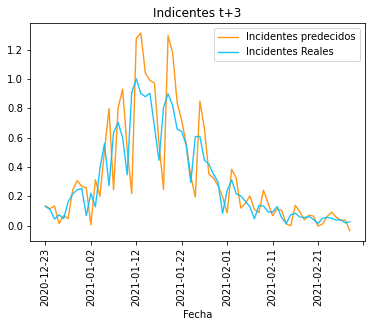

Mean absolute error = 0.13
RMSE = 0.2


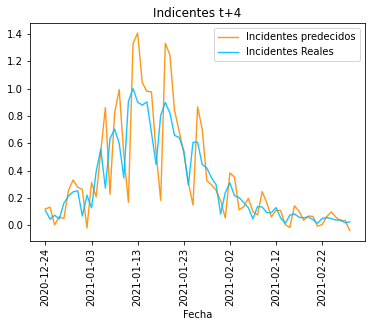

Mean absolute error = 0.14
RMSE = 0.22


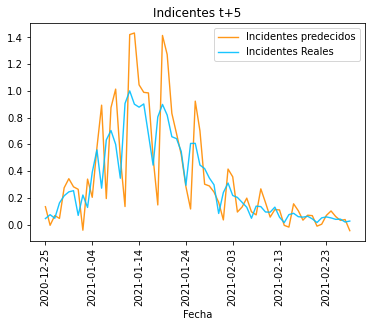

Mean absolute error = 0.16
RMSE = 0.24


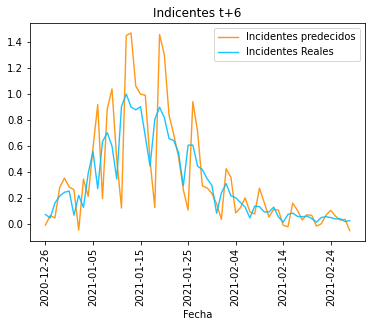

Mean absolute error = 0.17
RMSE = 0.25


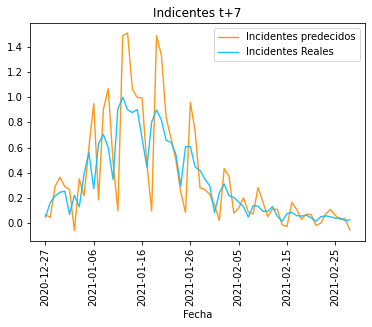

Mean absolute error = 0.17
RMSE = 0.26


In [107]:
MAE_en, RMSE_en = graficas_errores(predicciones_en_lag3, y_test_3)

In [108]:
for i in range(0, len(RMSE_en)):
    RMSEs_test_lag3_en.append(RMSE_en[i])
    MAEs_test_lag3_en.append(MAE_en[i])

In [109]:
calcular_cc(y_test_3, predicciones_en_lag3, CCs_test_lag3_en)

## Lag 5

In [264]:
clf_en = search_grid(elastic_net, grid, X_train_5, y_train_5)

In [265]:
clf_en.best_params_

{'alpha': 1e-05, 'l1_ratio': 0.13, 'max_iter': 10000, 'tol': 0.0001}

In [266]:
en_results = pd.DataFrame(clf_en.cv_results_)
en_results.head(3)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       0.136534      0.031766         0.002992    2.185142e-07       1e-05   
1       0.144114      0.020392         0.003192    3.989941e-04       1e-05   
2       0.135238      0.031426         0.003591    1.197243e-03       1e-05   

  param_l1_ratio param_max_iter param_tol  \
0              0          10000    0.0001   
1              0          10000     0.001   
2              0          10000      0.01   

                                              params  split0_test_score  ...  \
0  {'alpha': 1e-05, 'l1_ratio': 0.0, 'max_iter': ...          -0.013791  ...   
1  {'alpha': 1e-05, 'l1_ratio': 0.0, 'max_iter': ...          -0.013791  ...   
2  {'alpha': 1e-05, 'l1_ratio': 0.0, 'max_iter': ...          -0.013791  ...   

   split2_train_score  split3_train_score  split4_train_score  \
0           -0.003027           -0.002863           -0.003289   
1           -0.003027           -0.002863           -0.003289   
2           -0.003027           -0.002863           -0.003289   

   split5_train_score  split6_train_score  split7_train_score  \
0           -0.005275           -0.008989           -0.014612   
1           -0.005275           -0.008989           -0.014612   
2           -0.005275           -0.008989           -0.014612   

   split8_train_score  split9_train_score  mean_train_score  std_train_score  
0           -0.021377           -0.029597         -0.009384         0.009027  
1           -0.021377           -0.029597         -0.009384         0.009027  
2           -0.021377           -0.029597         -0.009384         0.009027  

[3 rows x 34 columns]

In [267]:
optimised_en = clf_en.best_estimator_

In [268]:
joblib.dump(optimised_en, 'en_lag5_escalado.pkl')

['en_lag5_escalado.pkl']

In [110]:
optimised_en_lag5 = joblib.load('en_lag5_escalado.pkl')

### Predicción t

In [111]:
y_pred = optimised_en_lag5.predict(X_test_5)

In [112]:
RMSEs_test_lag5_en = []
MAEs_test_lag5_en = []
CCs_test_lag5_en = []

RMSEs_test_lag5_en.append(RMSE(y_pred, y_test_5))
MAEs_test_lag5_en.append(MAE(y_pred, y_test_5))

RMSE = 0.13
Mean absolute error = 0.08


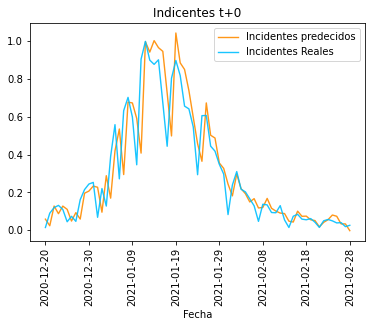

In [273]:
grafica(y_pred, y_test_5, -1)

In [113]:
CCs_test_lag5_en.append(round(np.corrcoef(y_test_5, y_pred)[0][1],3))

### Predicción 7 días adelante

In [114]:
predicciones_en_lag5 = calcular_predicciones_lag5(optimised_en_lag5, y_pred, X_test_5)

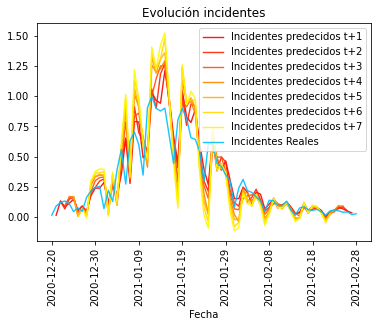

In [96]:
visualizar_predicciones(y_test_5, predicciones_en_lag5)

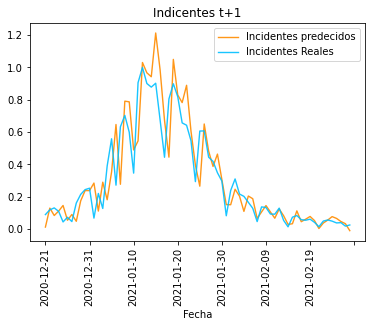

Mean absolute error = 0.09
RMSE = 0.14


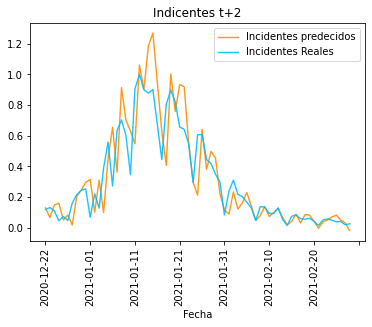

Mean absolute error = 0.1
RMSE = 0.15


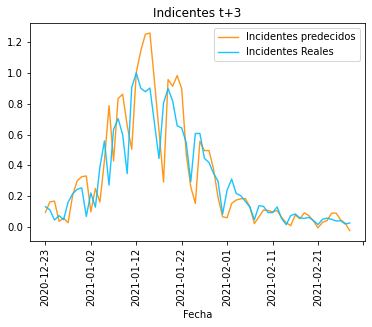

Mean absolute error = 0.11
RMSE = 0.17


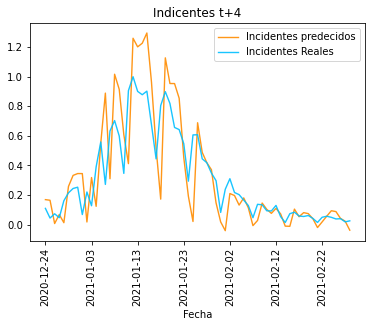

Mean absolute error = 0.14
RMSE = 0.21


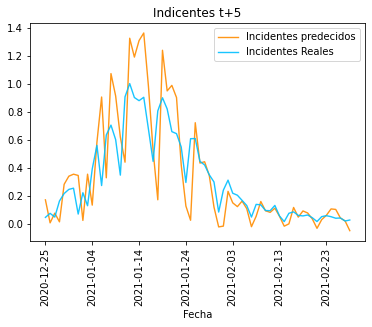

Mean absolute error = 0.15
RMSE = 0.22


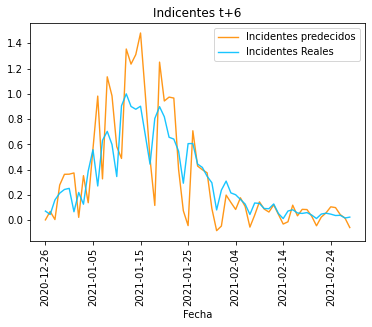

Mean absolute error = 0.17
RMSE = 0.24


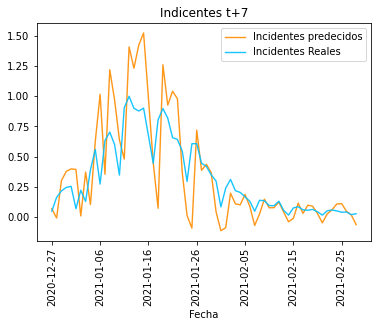

Mean absolute error = 0.19
RMSE = 0.27


In [115]:
MAE_en, RMSE_en = graficas_errores(predicciones_en_lag5, y_test_5)

In [116]:
for i in range(0, len(RMSE_en)):
    RMSEs_test_lag5_en.append(RMSE_en[i])
    MAEs_test_lag5_en.append(MAE_en[i])

In [117]:
calcular_cc(y_test_5, predicciones_en_lag5, CCs_test_lag5_en)

# Tablas de errores 

## CrossValidation

Para cada uno de los modelos hemos obtenido los mejores hiperparámetros. Ahora volveremos a entrenar los modelos usando validación cruzada de 10 pliegues (time series) y obteniendo para cada pliegue los errores RMSE, MAE y R^2

In [118]:
cv = TimeSeriesSplit(n_splits = 10)

In [119]:
scorings = ['neg_root_mean_squared_error', 'neg_median_absolute_error']

In [120]:
def obtener_rmse(scores):
    return (-1) * scores['test_neg_root_mean_squared_error']

In [121]:
def obtener_mae(scores):
    return (-1) * scores['test_neg_median_absolute_error']

Listas para añadir los errores de los splits para cada modelo en cada lag

In [122]:
RMSEs_train = []
MAEs_train = []

Una vez obtenidos todos los errores para cada uno de los modelos entonces creamos 6 dataframes, uno por error, tres para lag3 y otros tres para lag5. Las columnas son los modelos y las filas son los resultados de cada uno de los 10 folds

In [123]:
columnas = ['RF_lag3', 'RF_lag5', 'LR_lag3', 'LR_lag5', 'Lasso_lag3', 'Lasso_lag5', 'SVR_lag3', 'SVR_lag5', 'GBR_lag3', 'GBR_lag5', 'EN_lag3', 'EN_lag5' ]

In [124]:
filas_train = []
for i in range(1,11):
    filas_train.append('Fold ' + str(i))

In [125]:
def crear_dataframe_error_train(columnas, filas, errores):
    df = pd.DataFrame(0, columns = columnas, index = filas)
    df.index.name = 'Pliegues'
    for i in range(0, 12):
        df.iloc[:,i] = errores[i]
    return df

#### Random Forest

In [126]:
optimised_rf_lag3 = joblib.load('rf_lag3_escalado.pkl')
optimised_rf_lag5 = joblib.load('rf_lag5_escalado.pkl')

scores_RF_lag3 = cross_validate(optimised_rf_lag3, X_train_3, y_train_3, cv = cv, scoring = scorings)
scores_RF_lag5 = cross_validate(optimised_rf_lag5, X_train_5, y_train_5, cv = cv, scoring = scorings)

RMSEs_train.append(obtener_rmse(scores_RF_lag3))
MAEs_train.append(obtener_mae(scores_RF_lag3))

RMSEs_train.append(obtener_rmse(scores_RF_lag5))
MAEs_train.append(obtener_mae(scores_RF_lag5))

#### Linear Regression

In [127]:
scores_LR_lag3 = cross_validate(regresion_lineal_lag3, X_train_3, y_train_3, cv = cv, scoring = scorings)
scores_LR_lag5 = cross_validate(regresion_lineal_lag5, X_train_5, y_train_5, cv = cv, scoring = scorings)

RMSEs_train.append(obtener_rmse(scores_LR_lag3))
MAEs_train.append(obtener_mae(scores_LR_lag3))

RMSEs_train.append(obtener_rmse(scores_LR_lag5))
MAEs_train.append(obtener_mae(scores_LR_lag5))

#### Lasso

In [128]:
optimised_lasso_lag3 = joblib.load('lasso_lag3_escalado.pkl')
optimised_lasso_lag5 = joblib.load('lasso_lag5_escalado.pkl')

scores_lasso_lag3 = cross_validate(optimised_lasso_lag3, X_train_3, y_train_3, cv = cv, scoring = scorings)
scores_lasso_lag5 = cross_validate(optimised_lasso_lag5, X_train_5, y_train_5, cv = cv, scoring = scorings)

RMSEs_train.append(obtener_rmse(scores_lasso_lag3))
MAEs_train.append(obtener_mae(scores_lasso_lag3))

RMSEs_train.append(obtener_rmse(scores_lasso_lag5))
MAEs_train.append(obtener_mae(scores_lasso_lag5))

#### SVR

In [129]:
optimised_svr_lag3 = joblib.load('svr_lag3_escalado.pkl')
optimised_svr_lag5 = joblib.load('svr_lag5_escalado.pkl')

scores_svr_lag3 = cross_validate(optimised_svr_lag3, X_train_3, y_train_3, cv = cv, scoring = scorings)
scores_svr_lag5 = cross_validate(optimised_svr_lag5, X_train_5, y_train_5, cv = cv, scoring = scorings)

RMSEs_train.append(obtener_rmse(scores_svr_lag3))
MAEs_train.append(obtener_mae(scores_svr_lag3))

RMSEs_train.append(obtener_rmse(scores_svr_lag5))
MAEs_train.append(obtener_mae(scores_svr_lag5))

#### Gradient Boosting Regressor

In [130]:
optimised_gbr_lag3 = joblib.load('gbr_lag3_escalado.pkl')
optimised_gbr_lag5 = joblib.load('gbr_lag5_escalado.pkl')

scores_gbr_lag3 = cross_validate(optimised_gbr_lag3, X_train_3, y_train_3, cv = cv, scoring = scorings)
scores_gbr_lag5 = cross_validate(optimised_gbr_lag5, X_train_5, y_train_5, cv = cv, scoring = scorings)

RMSEs_train.append(obtener_rmse(scores_gbr_lag3))
MAEs_train.append(obtener_mae(scores_gbr_lag3))

RMSEs_train.append(obtener_rmse(scores_gbr_lag5))
MAEs_train.append(obtener_mae(scores_gbr_lag5))

#### Elastic Net

In [131]:
optimised_en_lag3 = joblib.load('en_lag3_escalado.pkl')
optimised_en_lag5 = joblib.load('en_lag5_escalado.pkl')

scores_en_lag3 = cross_validate(optimised_en_lag3, X_train_3, y_train_3, cv = cv, scoring = scorings)
scores_en_lag5 = cross_validate(optimised_en_lag5, X_train_5, y_train_5, cv = cv, scoring = scorings)

RMSEs_train.append(obtener_rmse(scores_en_lag3))
MAEs_train.append(obtener_mae(scores_en_lag3))

RMSEs_train.append(obtener_rmse(scores_en_lag5))
MAEs_train.append(obtener_mae(scores_en_lag5))

### Creación tablas crossvalidacion

### RMSE

Creamos los dataframes con los errores y los guardamos

In [132]:
RMSE_errores_train = crear_dataframe_error_train(columnas, filas_train, RMSEs_train)
RMSE_errores_train

RF_lag3   RF_lag5   LR_lag3   LR_lag5  Lasso_lag3  Lasso_lag5  \
Pliegues                                                                   
Fold 1    0.010250  0.012253  0.040040  0.021895    0.010777    0.012175   
Fold 2    0.003465  0.005035  0.006011  0.008859    0.005831    0.004163   
Fold 3    0.002359  0.002950  0.002599  0.004666    0.002282    0.002253   
Fold 4    0.005817  0.005213  0.008027  0.008158    0.006893    0.007117   
Fold 5    0.019228  0.018612  0.015113  0.017661    0.014720    0.014294   
Fold 6    0.097717  0.099564  0.030118  0.027917    0.031447    0.029454   
Fold 7    0.054043  0.054168  0.047621  0.046455    0.048174    0.044944   
Fold 8    0.117732  0.113723  0.064359  0.061369    0.063967    0.061773   
Fold 9    0.124888  0.141807  0.085793  0.091884    0.085716    0.091056   
Fold 10   0.060135  0.064386  0.029916  0.038327    0.029938    0.036199   

          SVR_lag3  SVR_lag5  GBR_lag3  GBR_lag5   EN_lag3   EN_lag5  
Pliegues                                                              
Fold 1    0.015468  0.017608  0.009779  0.011421  0.009565  0.011302  
Fold 2    0.006113  0.004916  0.003236  0.005702  0.005437  0.004665  
Fold 3    0.007964  0.006088  0.002058  0.001663  0.002220  0.002200  
Fold 4    0.012659  0.018517  0.005418  0.005386  0.006962  0.007347  
Fold 5    0.018877  0.022049  0.018109  0.019953  0.015303  0.015526  
Fold 6    0.031626  0.026445  0.094637  0.099538  0.031492  0.028937  
Fold 7    0.050317  0.046399  0.049422  0.054665  0.048253  0.045141  
Fold 8    0.066249  0.059950  0.118328  0.118405  0.064465  0.062454  
Fold 9    0.089009  0.093796  0.121939  0.142605  0.085260  0.091053  
Fold 10   0.029868  0.036866  0.048429  0.046525  0.029645  0.035670

In [133]:
RMSE_errores_train.to_csv(path_or_buf = '../Datos_preprocesados/RMSE_errores_train.csv')

In [134]:
RMSE_errores_train = read_csv('../Datos_preprocesados/RMSE_errores_train.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
RMSE_errores_train = RMSE_errores_train.set_index('Pliegues')

### MAE

In [135]:
MAE_errores_train = crear_dataframe_error_train(columnas, filas_train, MAEs_train)
MAE_errores_train

RF_lag3   RF_lag5   LR_lag3   LR_lag5  Lasso_lag3  Lasso_lag5  \
Pliegues                                                                   
Fold 1    0.008462  0.011392  0.032479  0.014992    0.007227    0.007082   
Fold 2    0.003400  0.005021  0.004186  0.003734    0.004024    0.002734   
Fold 3    0.001714  0.002173  0.001866  0.003266    0.001329    0.001685   
Fold 4    0.002247  0.002934  0.003994  0.002763    0.002256    0.002159   
Fold 5    0.012167  0.013229  0.011721  0.007150    0.011192    0.012083   
Fold 6    0.084448  0.087158  0.016943  0.016096    0.017917    0.016959   
Fold 7    0.033824  0.033456  0.026278  0.026127    0.025823    0.027261   
Fold 8    0.065309  0.056947  0.036142  0.032730    0.035894    0.033170   
Fold 9    0.098532  0.118379  0.052798  0.042889    0.055291    0.043395   
Fold 10   0.043867  0.055397  0.020134  0.024806    0.020085    0.023185   

          SVR_lag3  SVR_lag5  GBR_lag3  GBR_lag5   EN_lag3   EN_lag5  
Pliegues                                                              
Fold 1    0.012623  0.017494  0.007774  0.009879  0.006476  0.005981  
Fold 2    0.005366  0.003984  0.003021  0.005115  0.003658  0.003443  
Fold 3    0.005990  0.004277  0.001440  0.001243  0.001306  0.001632  
Fold 4    0.007597  0.010134  0.001828  0.001652  0.001959  0.002001  
Fold 5    0.014557  0.018390  0.012484  0.013561  0.012501  0.012333  
Fold 6    0.021310  0.012787  0.082231  0.087985  0.020494  0.016918  
Fold 7    0.034723  0.028557  0.022534  0.032382  0.026455  0.025546  
Fold 8    0.040139  0.031767  0.074404  0.061051  0.037323  0.032217  
Fold 9    0.059637  0.043899  0.099885  0.115925  0.054401  0.042336  
Fold 10   0.018272  0.020647  0.030652  0.040988  0.019380  0.022019

In [136]:
MAE_errores_train.to_csv(path_or_buf = '../Datos_preprocesados/MAE_errores_train.csv')

In [137]:
MAE_errores_train = read_csv('../Datos_preprocesados/MAE_errores_train.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
MAE_errores_train = MAE_errores_train.set_index('Pliegues')

## Test

In [138]:
columnas = ['RF_lag3', 'RF_lag5', 'LR_lag3', 'LR_lag5', 'Lasso_lag3', 'Lasso_lag5', 'SVR_lag3', 'SVR_lag5', 'GBR_lag3', 'GBR_lag5', 'EN_lag3', 'EN_lag5' ]

In [139]:
filas_test = []
for i in range(1,9):
    if i-1 == 0:
        filas_test.append('Predicción t')
    else:
        filas_test.append('Predicción t+' + str(i-1))

In [140]:
def crear_dataframe_error_test(columnas, filas, errores):
    df = pd.DataFrame(0, columns = columnas, index = filas)
    df.index.name = 'Predicciones'
    i = 0
    for c in df.columns:
        df[c] = errores[i]
        i = i+1
    return df

### RMSE

In [141]:
RMSEs_test = []
RMSEs_test.append(RMSEs_test_lag3_rf)
RMSEs_test.append(RMSEs_test_lag5_rf)
RMSEs_test.append(RMSEs_test_lag3_LR)
RMSEs_test.append(RMSEs_test_lag5_LR)
RMSEs_test.append(RMSEs_test_lag3_lasso)
RMSEs_test.append(RMSEs_test_lag5_lasso)
RMSEs_test.append(RMSEs_test_lag3_SVR)
RMSEs_test.append(RMSEs_test_lag5_SVR)
RMSEs_test.append(RMSEs_test_lag3_gbr)
RMSEs_test.append(RMSEs_test_lag5_gbr)
RMSEs_test.append(RMSEs_test_lag3_en)
RMSEs_test.append(RMSEs_test_lag5_en)

In [142]:
RMSE_errores_test = crear_dataframe_error_test(columnas, filas_test, RMSEs_test)
RMSE_errores_test

RF_lag3  RF_lag5  LR_lag3  LR_lag5  Lasso_lag3  Lasso_lag5  \
Predicciones                                                                 
Predicción t       0.22     0.23     0.13     0.13        0.13        0.13   
Predicción t+1     0.23     0.23     0.18     0.16        0.16        0.14   
Predicción t+2     0.23     0.23     0.21     0.17        0.20        0.16   
Predicción t+3     0.23     0.23     0.23     0.19        0.21        0.18   
Predicción t+4     0.23     0.23     0.27     0.25        0.23        0.22   
Predicción t+5     0.23     0.24     0.30     0.25        0.26        0.23   
Predicción t+6     0.24     0.24     0.32     0.30        0.27        0.25   
Predicción t+7     0.24     0.24     0.35     0.33        0.28        0.28   

                SVR_lag3  SVR_lag5  GBR_lag3  GBR_lag5  EN_lag3  EN_lag5  
Predicciones                                                              
Predicción t        0.13      0.13      0.21      0.21     0.13     0.13  
Predicción t+1      0.16      0.14      0.22      0.21     0.16     0.14  
Predicción t+2      0.19      0.15      0.22      0.22     0.19     0.15  
Predicción t+3      0.20      0.17      0.23      0.22     0.20     0.17  
Predicción t+4      0.23      0.21      0.23      0.22     0.22     0.21  
Predicción t+5      0.26      0.21      0.23      0.22     0.24     0.22  
Predicción t+6      0.27      0.24      0.23      0.22     0.25     0.24  
Predicción t+7      0.30      0.27      0.23      0.22     0.26     0.27

In [143]:
RMSE_errores_test.to_csv(path_or_buf = '../Datos_preprocesados/RMSE_errores_test.csv')

In [144]:
RMSE_errores_test = read_csv('../Datos_preprocesados/RMSE_errores_test.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
RMSE_errores_test = RMSE_errores_test.set_index('Predicciones')

### MAE

In [145]:
MAEs_test = []
MAEs_test.append(MAEs_test_lag3_rf)
MAEs_test.append(MAEs_test_lag5_rf)
MAEs_test.append(MAEs_test_lag3_LR)
MAEs_test.append(MAEs_test_lag5_LR)
MAEs_test.append(MAEs_test_lag3_lasso)
MAEs_test.append(MAEs_test_lag5_lasso)
MAEs_test.append(MAEs_test_lag3_SVR)
MAEs_test.append(MAEs_test_lag5_SVR)
MAEs_test.append(MAEs_test_lag3_gbr)
MAEs_test.append(MAEs_test_lag5_gbr)
MAEs_test.append(MAEs_test_lag3_en)
MAEs_test.append(MAEs_test_lag5_en)

In [146]:
MAE_errores_test = crear_dataframe_error_test(columnas, filas_test, MAEs_test)
MAE_errores_test

RF_lag3  RF_lag5  LR_lag3  LR_lag5  Lasso_lag3  Lasso_lag5  \
Predicciones                                                                 
Predicción t       0.14     0.14     0.09     0.08        0.09        0.08   
Predicción t+1     0.15     0.15     0.11     0.11        0.10        0.09   
Predicción t+2     0.15     0.15     0.14     0.12        0.13        0.11   
Predicción t+3     0.15     0.15     0.15     0.13        0.13        0.12   
Predicción t+4     0.15     0.15     0.17     0.17        0.15        0.15   
Predicción t+5     0.15     0.15     0.19     0.17        0.17        0.16   
Predicción t+6     0.15     0.16     0.21     0.21        0.17        0.17   
Predicción t+7     0.16     0.16     0.23     0.23        0.19        0.19   

                SVR_lag3  SVR_lag5  GBR_lag3  GBR_lag5  EN_lag3  EN_lag5  
Predicciones                                                              
Predicción t        0.09      0.08      0.13      0.13     0.09     0.08  
Predicción t+1      0.10      0.09      0.14      0.14     0.10     0.09  
Predicción t+2      0.12      0.10      0.14      0.14     0.12     0.10  
Predicción t+3      0.13      0.11      0.14      0.14     0.13     0.11  
Predicción t+4      0.15      0.14      0.14      0.14     0.14     0.14  
Predicción t+5      0.17      0.14      0.15      0.14     0.16     0.15  
Predicción t+6      0.18      0.16      0.15      0.14     0.17     0.17  
Predicción t+7      0.20      0.19      0.15      0.14     0.17     0.19

In [147]:
MAE_errores_test.to_csv(path_or_buf = '../Datos_preprocesados/MAE_errores_test.csv')

In [148]:
MAE_errores_test = read_csv('../Datos_preprocesados/MAE_errores_test.csv', encoding='latin-1', sep = ',', na_values = ['NaN', 'NaT'])
MAE_errores_test = MAE_errores_test.set_index('Predicciones')

## Gráficas Train

### Random Forest

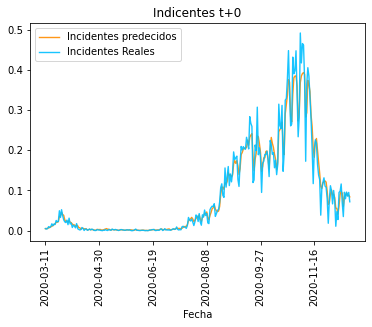

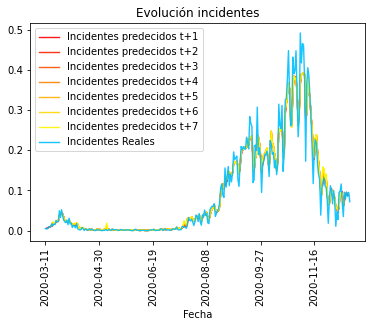

In [149]:
y_pred_train_rf_lag3 = optimised_rf_lag3.predict(X_train_3)

grafica(y_pred_train_rf_lag3, y_train_3, -1)

predicciones_train_rf_lag3 = calcular_predicciones_lag3(optimised_rf_lag3, y_pred_train_rf_lag3, X_train_3)

visualizar_predicciones(y_train_3, predicciones_train_rf_lag3)

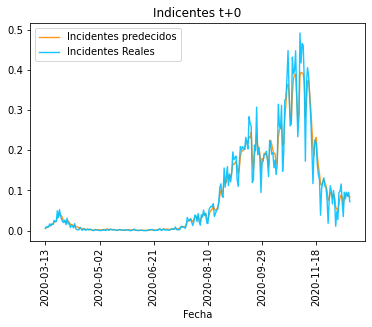

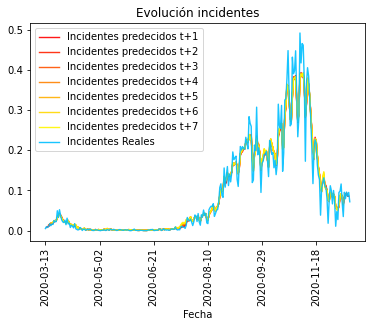

In [150]:
y_pred_train_rf_lag5 = optimised_rf_lag5.predict(X_train_5)

grafica(y_pred_train_rf_lag5, y_train_5, -1)

predicciones_train_rf_lag5 = calcular_predicciones_lag5(optimised_rf_lag5, y_pred_train_rf_lag5, X_train_5)

visualizar_predicciones(y_train_5, predicciones_train_rf_lag5)

### Linear Regression

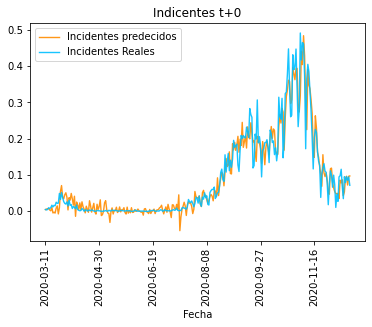

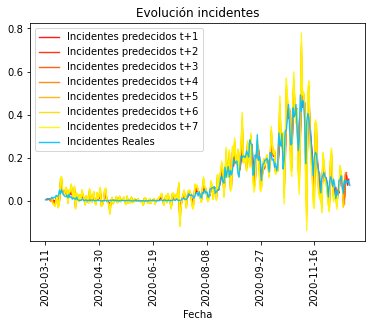

In [151]:
y_pred_train_LR_lag3 = regresion_lineal_lag3.predict(X_train_3)

grafica(y_pred_train_LR_lag3, y_train_3, -1)

predicciones_train_LR_lag3 = calcular_predicciones_lag3(regresion_lineal_lag3 , y_pred_train_LR_lag3, X_train_3)

visualizar_predicciones(y_train_3, predicciones_train_LR_lag3)

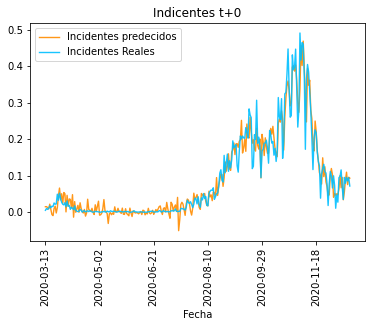

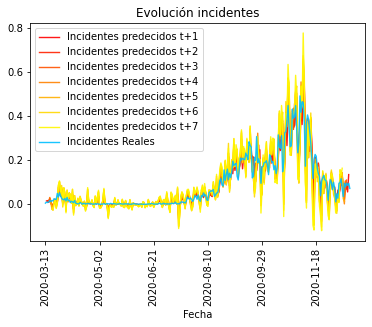

In [152]:
y_pred_train_LR_lag5 = regresion_lineal_lag5.predict(X_train_5)

grafica(y_pred_train_LR_lag5, y_train_5, -1)

predicciones_train_LR_lag5 = calcular_predicciones_lag5(regresion_lineal_lag5, y_pred_train_LR_lag5, X_train_5)

visualizar_predicciones(y_train_5, predicciones_train_LR_lag5)

### Lasso

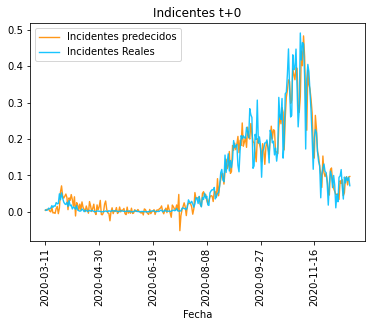

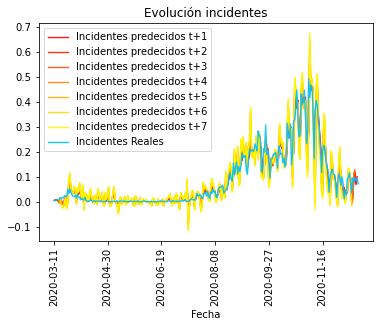

In [153]:
y_pred_train_lasso_lag3 = optimised_lasso_lag3.predict(X_train_3)

grafica(y_pred_train_lasso_lag3, y_train_3, -1)

predicciones_train_lasso_lag3 = calcular_predicciones_lag3(optimised_lasso_lag3, y_pred_train_lasso_lag3, X_train_3)

visualizar_predicciones(y_train_3, predicciones_train_lasso_lag3)

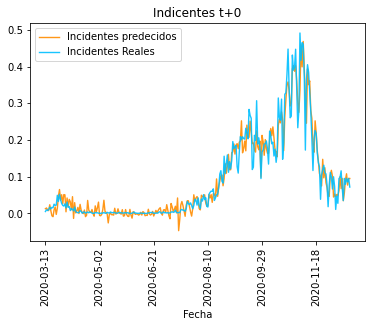

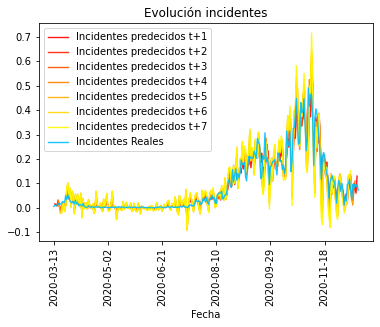

In [154]:
y_pred_train_lasso_lag5 = optimised_lasso_lag5.predict(X_train_5)

grafica(y_pred_train_lasso_lag5, y_train_5, -1)

predicciones_train_lasso_lag5 = calcular_predicciones_lag5(optimised_lasso_lag5, y_pred_train_lasso_lag5, X_train_5)

visualizar_predicciones(y_train_5, predicciones_train_lasso_lag5)

### Gradient Boosting Regressor

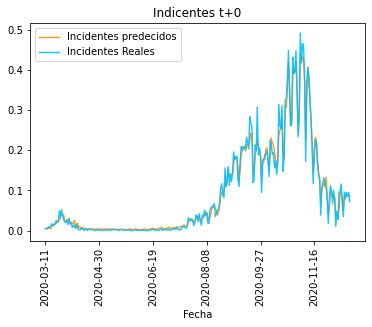

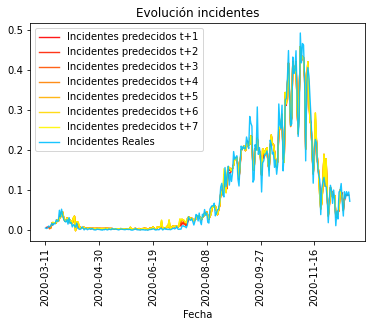

In [155]:
y_pred_train_gbr_lag3 = optimised_gbr_lag3.predict(X_train_3)

grafica(y_pred_train_gbr_lag3, y_train_3, -1)

predicciones_train_gbr_lag3 = calcular_predicciones_lag3(optimised_gbr_lag3, y_pred_train_gbr_lag3, X_train_3)

visualizar_predicciones(y_train_3, predicciones_train_gbr_lag3)

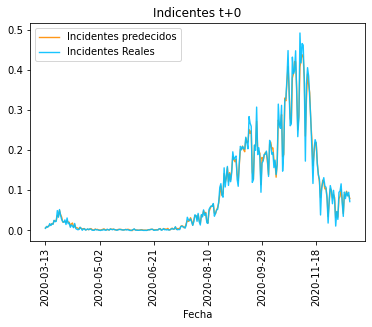

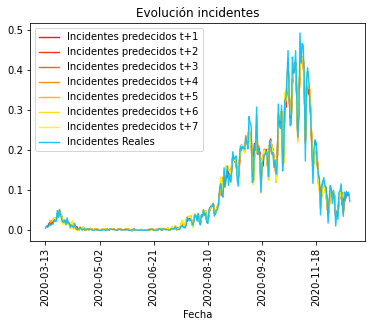

In [156]:
y_pred_train_gbr_lag5 = optimised_gbr_lag5.predict(X_train_5)

grafica(y_pred_train_gbr_lag5, y_train_5, -1)

predicciones_train_gbr_lag5 = calcular_predicciones_lag5(optimised_gbr_lag5, y_pred_train_gbr_lag5, X_train_5)

visualizar_predicciones(y_train_5, predicciones_train_gbr_lag5)

### SVR

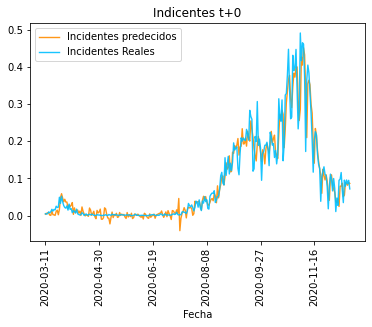

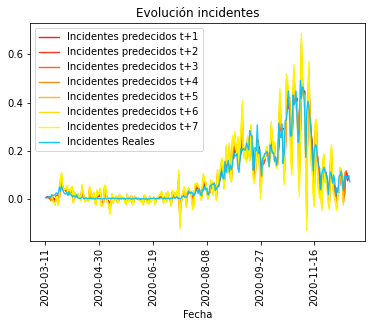

In [157]:
y_pred_train_svr_lag3 = optimised_svr_lag3.predict(X_train_3)

grafica(y_pred_train_svr_lag3, y_train_3, -1)

predicciones_train_svr_lag3 = calcular_predicciones_lag3(optimised_svr_lag3, y_pred_train_svr_lag3, X_train_3)

visualizar_predicciones(y_train_3, predicciones_train_svr_lag3)

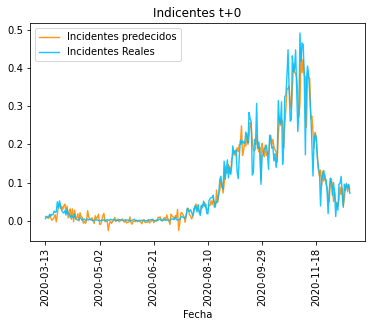

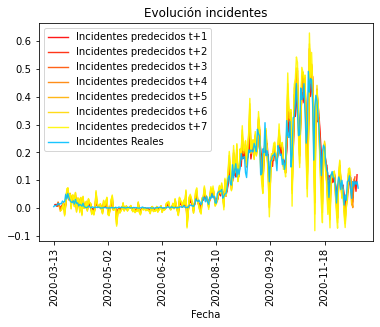

In [158]:
y_pred_train_svr_lag5 = optimised_svr_lag5.predict(X_train_5)

grafica(y_pred_train_svr_lag5, y_train_5, -1)

predicciones_train_svr_lag5 = calcular_predicciones_lag5(optimised_svr_lag5, y_pred_train_svr_lag5, X_train_5)

visualizar_predicciones(y_train_5, predicciones_train_svr_lag5)

### Elastic Net

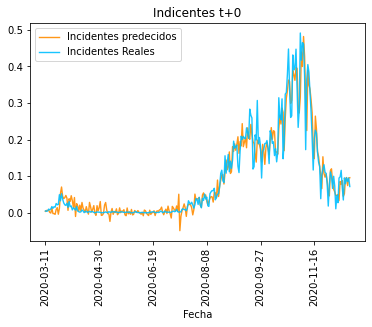

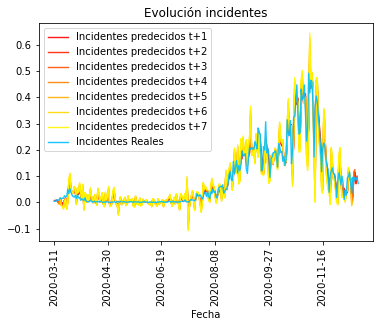

In [159]:
y_pred_train_en_lag3 = optimised_en_lag3.predict(X_train_3)

grafica(y_pred_train_en_lag3, y_train_3, -1)

predicciones_train_en_lag3 = calcular_predicciones_lag3(optimised_en_lag3, y_pred_train_en_lag3, X_train_3)

visualizar_predicciones(y_train_3, predicciones_train_en_lag3)

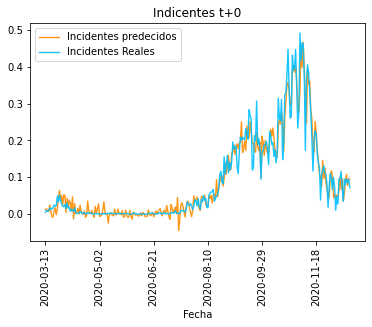

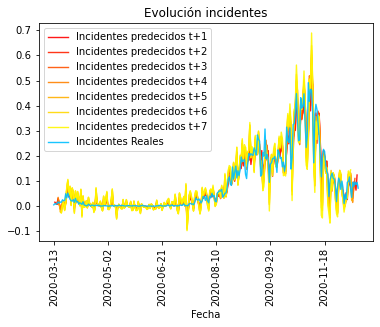

In [160]:
y_pred_train_en_lag5 = optimised_en_lag5.predict(X_train_5)

grafica(y_pred_train_en_lag5, y_train_5, -1)

predicciones_train_en_lag5 = calcular_predicciones_lag5(optimised_en_lag5, y_pred_train_en_lag5, X_train_5)

visualizar_predicciones(y_train_5, predicciones_train_en_lag5)